# Photometric Color correction in FGCM Model

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : November 23th 2022
- update : November 26th 2022

## Goal Study color bias wrt airmass

### Interpretable standard magnitude expression : option A : with zero point as unit observed counting rate

$$
\begin{eqnarray}
m_b^{std} & = &  -2.5 \log_{10}(C_b^{obs})+ 2.5 \log_{10}\left(\frac{\mathbb{I}_0^{std}(b)}{\mathbb{I}_0^{obs}}\right) + m_b^{obs}(ZPT)   \nonumber \\
 & & + 2.5 \log_{10} 
	\left( 
	\frac{\int_0^\infty F_\nu(\lambda) \times S_b^{obs}(\lambda) \frac{d\lambda}{\lambda} }{\int_0^\infty F_\nu(\lambda) \times S_b^{std}(\lambda) \frac{d\lambda}{\lambda}} 
	\right)
\end{eqnarray}
$$

### Interpretable standard magnitude expression : option B : with zero point as constant

$$
\begin{eqnarray}
m_b^{std} & = &  -2.5 \log_{10}(C_b^{obs})+ 2.5 \log_{10}\left(\mathbb{I}_0^{std}(b)\right) + ZPT^{AB}   \nonumber \\
 & & + 2.5 \log_{10} 
	\left( 
	\frac{\int_0^\infty F_\nu(\lambda) \times S_b^{obs}(\lambda) \frac{d\lambda}{\lambda} }{\int_0^\infty F_\nu(\lambda) \times S_b^{std}(\lambda) \frac{d\lambda}{\lambda}} 
	\right)
\end{eqnarray}
$$

### Standard Magnitude wit SED approximation

- we don't know the exact SED of some reference calibration stars (in LSST, for Auxtel)

$$
F_{\nu}(\lambda) = F_\nu(\lambda_b) \times \left(1 + f_\nu^\prime(\lambda_b)(\lambda-\lambda_b) + \frac{f_\nu^{\prime\prime}(\lambda_b)}{2}(\lambda-\lambda_b)^2 + \cdots \right)
$$

$$
\begin{eqnarray}
m_b^{std} & = & -2.5 \log_{10}(C_b)  \nonumber \\
          &   &  + 2.5 \log_{10}(\mathbb{I}_0^{obs}(b)) + ZPT^{AB}  \nonumber \\
          &   &  + 1.087\left( f_\nu^\prime(\lambda_b) \Delta \mathbb{I}_{10}(b) +
          \frac{f_\nu^{\prime\prime}(\lambda_b)}{2}\Delta \mathbb{I}_{20}(b) \right. 
         - \left. \frac{1}{2}\left( f_\nu^\prime(\lambda_b) \Delta \mathbb{I}_{10}(b) \right)^2             
          \right)
\end{eqnarray}
$$

### Error on Color Photometric Correction
$$
\begin{eqnarray}
\Delta m & = & \left| 2.5 \log_{10}\left(
\frac{\mathbb{I}_0^{std}(b)}
{\mathbb{I}_0^{obs}(b)}\right) +
2.5 \log_{10} 
	\left( 
	\frac{\int_0^\infty F_\nu(\lambda) \times S_b^{obs}(\lambda) \frac{d\lambda}{\lambda} }{\int_0^\infty F_\nu(\lambda) \times S_b^{std}(\lambda) \frac{d\lambda}{\lambda}} 
	\right) \right. \nonumber \\
    & & \left. - 1.087\left( f_\nu^\prime(\lambda_b) \Delta \mathbb{I}_{10}(b) +
          \frac{f_\nu^{\prime\prime}(\lambda_b)}{2}\Delta \mathbb{I}_{20}(b) \right. 
         - \left. \frac{1}{2}\left( f_\nu^\prime(\lambda_b) \Delta \mathbb{I}_{10}(b) \right)^2             
          \right)\right|
\end{eqnarray}  
$$

## Import

In [1]:
# Import some generally useful packages

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
import pandas as pd
from itertools import cycle, islice

In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)


In [3]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [4]:
from scipy import interpolate

In [5]:
# Import the primary photometry classes from rubin_sim.photUtils

import rubin_sim.photUtils.Bandpass as Bandpass
import rubin_sim.photUtils.Sed as Sed
from rubin_sim.data import get_data_dir

In [6]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits',
 'comptable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits',
 'thermtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [7]:
from libradtranpy import  libsimulateVisible

libradtranpath= /Users/dagoret/MacOSX/External/libRadtran2/


In [8]:
import warnings
warnings.filterwarnings("ignore")

## Configuration

### LSST Throughput

In [9]:
path_throughput="/sps/lsst/groups/auxtel/softs/github/desc/throughputs/baseline"
path_throughput=os.path.join(os.getenv("HOME"),"rubin_sim_data/throughputs/baseline") 

In [10]:
atm_std_filename = "atmos_std.dat"

In [11]:
filter_filenames = ["total_u.dat","total_g.dat","total_r.dat","total_i.dat","total_z.dat","total_y.dat" ]
filter_tagnames = ["u","g","r","i","z","y"]
filter_color = ["b","g","r","orange","grey","k"]
NFILT=len(filter_filenames)

### Wavelength range and sampling

In [12]:
WLMIN=300.
WLMAX=1100.
WLBIN=1.
NWLBIN=int((WLMAX-WLMIN)/WLBIN)
WL=np.linspace(WLMIN,WLMAX,NWLBIN)

In [13]:
assert NWLBIN == len(WL)

### Backup observed air transparency

In [14]:
FLAG_BACKUP_ATMSIM = True
FLAG_ATMSIM_READFROMFILE = True
atmsim_backup_filename = "atmossim_obs_varyairmass_16values.dat"

### Replace the standard atmosphere

In [15]:
FLAG_REPLACE_STANDARD_ATMOS = True
index_replace_atm=2

## Initialisation

In [16]:
df_std=pd.DataFrame()

In [17]:
df_std["wl"] = WL

### Standard atmosphere

In [18]:
fullfilename=os.path.join(path_throughput,atm_std_filename)

In [19]:
arr= np.loadtxt(fullfilename)

In [20]:
#f = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value="extrapolate")
f = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value=1)

In [21]:
atm_std=f(WL)

In [22]:
df_std["atm"] = atm_std

### Total filters

FILTERWL:

- index 0 : minimum wavelength of filter border
- index 1 : minimum wavelength of filter border
- index 2 : center wavelength of filter 
- index 3 : filter width

In [23]:
FILTERWL = np.zeros((NFILT,4))

# loop on filter
for index,filename in enumerate(filter_filenames):
    fullfilename=os.path.join(path_throughput,filename)
    arr= np.loadtxt(fullfilename)
    
    # interpolate  filter transmission
    ff = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value="extrapolate")
    
    # filter throughput including atm
    throughput1=ff(WL)
    # filter throughput without atm
    throughput2=throughput1/atm_std
    
    tag1="tot_"+filter_tagnames[index]
    tag2="inst_"+filter_tagnames[index]
    
    df_std[tag1]= throughput1
    df_std[tag2]= throughput2
    
    indexes=np.where(throughput2>0.05)[0]
    #left border of filter
    FILTERWL[index,0]=WL[indexes.min()] 
    # right border of the filter
    FILTERWL[index,1]=WL[indexes.max()] 
    # width of the filter
    FILTERWL[index,3]=WL[indexes.max()]-WL[indexes.min()]  
    #lambda_b
    lambdab=np.trapz(throughput2,WL)/np.trapz(throughput2/WL,WL)
    FILTERWL[index,2]=lambdab

In [24]:
FILTERWL

array([[ 324.03003755,  402.12765957,  363.59690349,   78.09762203],
       [ 392.11514393,  561.32665832,  473.54069923,  169.21151439],
       [ 542.3028786 ,  700.50062578,  619.49926767,  158.19774718],
       [ 681.47684606,  827.65957447,  752.01084117,  146.18272841],
       [ 808.63579474,  932.79098874,  868.488419  ,  124.15519399],
       [ 914.76846058, 1044.93116395,  969.10570859,  130.16270338]])

Text(0.5, 1.0, 'Instrument transmission')

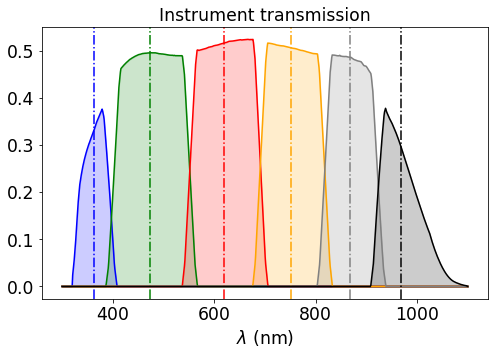

In [25]:
fig, axs = plt.subplots(1,1,figsize=(8,5))
for index in range(NFILT):
    tag="inst_"+filter_tagnames[index]
    axs.plot(WL,df_std[tag].values,color=filter_color[index]) 
    axs.fill_between(WL,df_std[tag].values,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    #plt.axvline(FILTERWL[index,0],color=filter_color[index],linestyle=":")
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument transmission")

Text(0.5, 1.0, 'Instrument and atmosphere transmission')

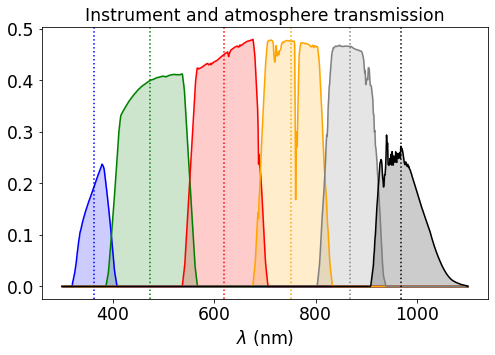

In [26]:
fig, axs = plt.subplots(1,1,figsize=(8,5))
for index in range(NFILT):
    tag="tot_"+filter_tagnames[index]
    axs.plot(WL,df_std[tag].values,color=filter_color[index]) 
    axs.fill_between(WL,df_std[tag].values,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle=":")
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument and atmosphere transmission")

In [27]:
df_std.head()

wl       atm  tot_u  inst_u  tot_g  inst_g  tot_r  inst_r  tot_i  \
0  300.000000  0.006410    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
1  301.001252  0.011915    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
2  302.002503  0.017428    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
3  303.003755  0.026622    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
4  304.005006  0.035820    0.0     0.0    0.0     0.0    0.0     0.0    0.0   

   inst_i  tot_z  inst_z  tot_y  inst_y  
0     0.0    0.0     0.0    0.0     0.0  
1     0.0    0.0     0.0    0.0     0.0  
2     0.0    0.0     0.0    0.0     0.0  
3     0.0    0.0     0.0    0.0     0.0  
4     0.0    0.0     0.0    0.0     0.0

## Functions

### Functions on passband Integrals 

$$
\mathbb{I}_0(b) \equiv \int_0^\infty S_b(\lambda) \frac{d\lambda}{\lambda}
$$

In [28]:
def fII0(wl,s):
    return np.trapz(s/wl,wl)

$$
\mathbb{I}_1(b) \equiv \int_0^\infty S_b(\lambda)(\lambda - \lambda_b) \frac{d\lambda}{\lambda}
$$

In [29]:
def fII1(wl,s,wlb):
    return np.trapz(s*(wl-wlb)/wl,wl)

$$
\mathbb{I}_2(b) \equiv \int_0^\infty S_b(\lambda)(\lambda-\lambda_b)^2 \frac{d\lambda}{\lambda}
$$

In [30]:
def fII2(wl,s,wlb):
    return np.trapz(s*(wl-wlb)**2/wl,wl)

$$
\mathbb{I}_{10}(b) \equiv \frac{\mathbb{I}_{1}(b)}{\mathbb{I}_{0}(b)}
$$

In [31]:
def fII10(wl,s,wlb):
    return fII1(wl,s,wlb)/fII0(wl,s)

$$
\mathbb{I}_{20}(b) \equiv \frac{\mathbb{I}_{2}(b)}{\mathbb{I}_{0}(b)}
$$

In [32]:
def fII20(wl,s,wlb):
    return fII2(wl,s,wlb)/fII0(wl,s)

### CalculateIIntegrals(df_S,wlb)

In [33]:
def CalculateIIntegrals(df_S,wlb):
    """
    
    input : 
     - df_S : dataframe containing transmission (atmosphere + instrument) 
     - lambda_b : center of passband
     
    output:
     - dataframe containing the integrals II0,II1,II2, II10, II20 for each filter (u,g,r,i,z,y)
     
    """
    II0 = np.zeros(NFILT)
    II1 = np.zeros(NFILT)
    II2 = np.zeros(NFILT)
    II10 = np.zeros(NFILT)
    II20 = np.zeros(NFILT)
    
    for index in range(NFILT):
        tag="tot_"+filter_tagnames[index]
        wl=df_S["wl"].values
        S=df_S[tag].values
        II0[index] = fII0(wl,S)
        II1[index] = fII1(wl,S,wlb[index])
        II2[index] = fII2(wl,S,wlb[index])
        II10[index] = fII10(wl,S,wlb[index])
        II20[index] = fII20(wl,S,wlb[index])
        
    df_II = pd.DataFrame()
    df_II["II0"]=II0
    df_II["II1"]=II1
    df_II["II2"]=II2
    df_II["II10"]=II10
    df_II["II20"]=II20    
    return df_II
    

## Calculate Integrals for Standard atmosphere

### Function SED integrals

- compute average over passband

$$
\frac{
\int_0^\infty q(\lambda) S_b^{tot} \frac{d\lambda}{\lambda}
}
{
\int_0^\infty  S_b^{tot} \frac{d\lambda}{\lambda}
}
$$

In [34]:
def ComputeAverage(the_wl,the_q,df_S):
    """
    
    input parameters:
      - the_wl : the wavelength array of the quantity over which one integrate
      - the_q : the quantity over which one integrate (ex the SED flux)
      - df_S : the passbands over which one integrates
      
    output:
      - all_qq_average : average over the_q in each passband (array)
      
    """
    
    
    # quantity that must be average
    func = interpolate.interp1d(x=the_wl, y=the_q,fill_value="extrapolate")
    qq_interp = func(WL)
    
    # Output for the average
    all_qq_average= np.zeros(NFILT)
    
    # loop on filters
    for index in range(NFILT):
        tag="tot_"+filter_tagnames[index]
        wl=df_S["wl"].values
        S = df_S[tag].values
        # weight for the average
        W = S/wl
        qq_average_inband = np.sum(W*qq_interp)/W.sum()
        all_qq_average[index] = qq_average_inband
    
    return all_qq_average
        

### Calculate Integrals for Standard atmosphere

In [35]:
df_IIstd = CalculateIIntegrals(df_std,FILTERWL[:,2])

In [36]:
df_IIstd 

II0       II1         II2      II10         II20
0  0.033338  0.079194   12.612354  2.375463   378.312338
1  0.121926  0.305935  230.105550  2.509184  1887.257382
2  0.100710  0.096977  167.700718  0.962933  1665.181331
3  0.077127  0.025279  109.332320  0.327765  1417.570239
4  0.053724 -0.024968   50.296178 -0.464738   936.189562
5  0.025932  0.089871   32.480106  3.465616  1252.500277

## Creation of observed transmission and set Airmass variation effect

- create a dataframe df_obs containing all info related to observed atmosphere

### Simulation in libradtran

In [37]:
all_am = np.linspace(1,2.5,16)
NAM=len(all_am)
pwv= 3
aer= 0.04
oz = 300

In [38]:
all_am_tags = []
for index,am in enumerate(all_am):
    am_tag = "am_"+str(int(am*10))
    all_am_tags.append(am_tag)
all_am_tags=np.array(all_am_tags)
all_am_tags

array(['am_10', 'am_11', 'am_12', 'am_13', 'am_14', 'am_15', 'am_16',
       'am_17', 'am_18', 'am_19', 'am_20', 'am_21', 'am_22', 'am_23',
       'am_24', 'am_25'], dtype='<U5')

### Read the simulation of atmosphere if already backuped and fill df_obs

In [39]:
simulation_backupfile_found = False

if FLAG_ATMSIM_READFROMFILE:
    if os.path.exists(atmsim_backup_filename):
        arr=np.loadtxt(atmsim_backup_filename)
        
        nwlsim = arr.shape[0]
        ntranspsim = arr.shape[1]
        
        #check if format is convenient
        if nwlsim == NWLBIN and ntranspsim == NAM:
            simulation_backupfile_found = True
            
            all_df_obs = []
            
            for index_am,am in enumerate(all_am):
                atm = arr[:,index_am]
                df_obs=pd.DataFrame()
                df_obs["wl"] = WL
                df_obs["atm"] = atm
                
                for findex in range(NFILT):
                    tag1="tot_"+filter_tagnames[findex]
                    tag2="inst_"+filter_tagnames[findex]
    
                    df_obs[tag1]= df_std[tag2].values*atm
                    df_obs[tag2]= df_std[tag2].values
    
                all_df_obs.append(df_obs)
        else:
            print(f"Not convenient format for file {atmsim_backup_filename}")
    else:
        print(f"file {atmsim_backup_filename} does not exist")

In [40]:
try:
    all_df_obs
except NameError:
    var_exists = False
else:
    if len(all_df_obs) >0:
        var_exists = True
    else:
        var_exists = True
var_exists

True

### If all_df_obs does not exist, then simulate 

In [41]:
if not var_exists:
    
    all_df_obs = []

    # if want to save this simulation
    if FLAG_BACKUP_ATMSIM:
        arrout = np.zeros((NWLBIN,NAM))

    # loop on airmass
    for index,am in enumerate(all_am):
        path,thefile = libsimulateVisible.ProcessSimulationaer(am,pwv,oz,aer,0,prof_str='us',proc_str='sa',cloudext=0.0, FLAG_VERBOSE=False)
        data = np.loadtxt(os.path.join(path,thefile))
        f = interpolate.interp1d(x=data[:,0], y=data[:,1],fill_value="extrapolate")
        atm=f(WL)
    
        # backup in simulation in the array
        if FLAG_BACKUP_ATMSIM:
            arrout[:,index]=atm 
        
    
        df_obs=pd.DataFrame()
        df_obs["wl"] = WL
        df_obs["atm"] = atm
    
    
        for findex in range(NFILT):
            tag1="tot_"+filter_tagnames[findex]
            tag2="inst_"+filter_tagnames[findex]
    
            df_obs[tag1]= df_std[tag2].values*atm
            df_obs[tag2]= df_std[tag2].values
    
        all_df_obs.append(df_obs)
        
    if FLAG_BACKUP_ATMSIM:
        np.savetxt(atmsim_backup_filename, arrout)
    

### Plot observed atmospheric  transmission and comparison with standard atmosphere

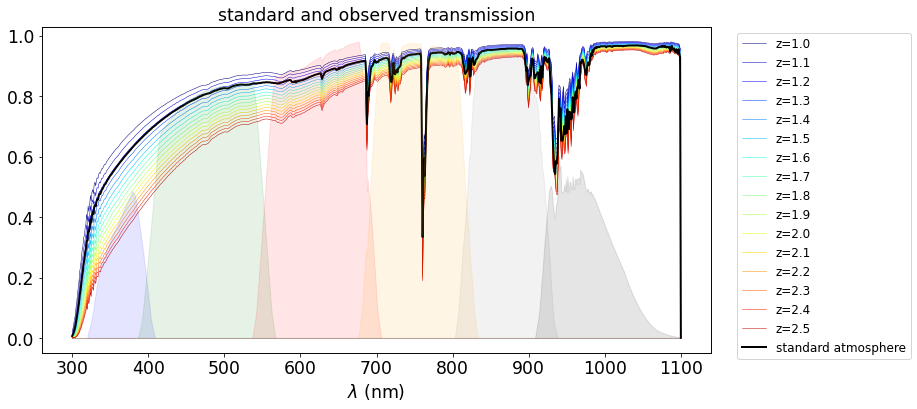

In [42]:
NOBS = len(all_df_obs)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig, axs = plt.subplots(1,1,figsize=(12,6))

for index,obs in enumerate(all_df_obs):
    atm = obs["atm"].values
    am = all_am[index]
    label = f"z={am:.1f}"
    
    axs.plot(WL,atm,color=all_colors[index],label=label,lw=0.5)

    
    
axs.plot(WL,df_std["atm"].values,color="k",lw=2,label="standard atmosphere")
axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")


ax2 = axs.twinx()
for ifilt in range(NFILT):
    tag="tot_"+filter_tagnames[ifilt]
    #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
    ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])



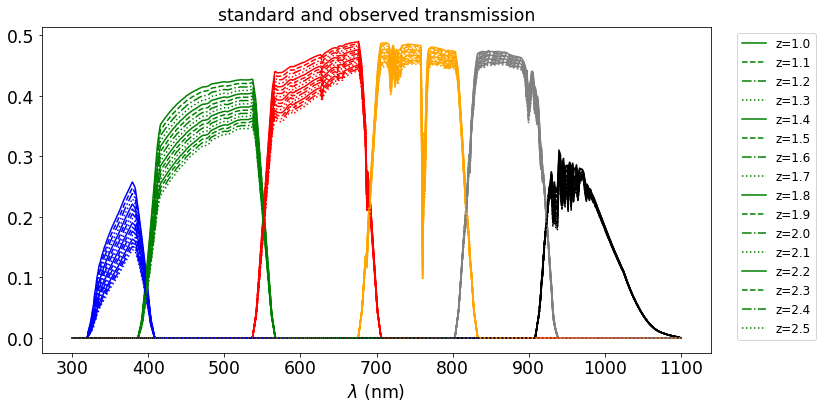

In [43]:
fig, axs = plt.subplots(1,1,figsize=(12,6))

all_linestyles = ['-','--','-.',':','-','--','-.',':','-','--','-.',':','-','--','-.',':']


for idx_atm,the_obs in enumerate(all_df_obs):
    
    am = all_am[idx_atm]
    label = f"z={am:.1f}"
    
    for findex in range(NFILT):
        tag1="tot_"+filter_tagnames[findex]
        tag2="inst_"+filter_tagnames[findex]

        if findex==1:
            axs.plot(the_obs["wl"],the_obs[tag1],color=filter_color[findex],linestyle=all_linestyles[idx_atm],label=label )
        else:
            axs.plot(the_obs["wl"],the_obs[tag1],color=filter_color[findex],linestyle=all_linestyles[idx_atm])

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")
axs.legend(bbox_to_anchor=(1.03, 1.0))  

In [44]:
all_df_obs[0].head()

wl       atm  tot_u  inst_u  tot_g  inst_g  tot_r  inst_r  tot_i  \
0  300.000000  0.021341    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
1  301.001252  0.031250    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
2  302.002503  0.042930    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
3  303.003755  0.062760    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
4  304.005006  0.072332    0.0     0.0    0.0     0.0    0.0     0.0    0.0   

   inst_i  tot_z  inst_z  tot_y  inst_y  
0     0.0    0.0     0.0    0.0     0.0  
1     0.0    0.0     0.0    0.0     0.0  
2     0.0    0.0     0.0    0.0     0.0  
3     0.0    0.0     0.0    0.0     0.0  
4     0.0    0.0     0.0    0.0     0.0

### Replace standard atmosphere with known atmosphere

In [45]:
if FLAG_REPLACE_STANDARD_ATMOS:
    df_std=all_df_obs[index_replace_atm]
    df_IIstd = CalculateIIntegrals(df_std,FILTERWL[:,2])

In [46]:
df_std.head()

wl       atm  tot_u  inst_u  tot_g  inst_g  tot_r  inst_r  tot_i  \
0  300.000000  0.009887    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
1  301.001252  0.015625    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
2  302.002503  0.022874    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
3  303.003755  0.036076    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
4  304.005006  0.042779    0.0     0.0    0.0     0.0    0.0     0.0    0.0   

   inst_i  tot_z  inst_z  tot_y  inst_y  
0     0.0    0.0     0.0    0.0     0.0  
1     0.0    0.0     0.0    0.0     0.0  
2     0.0    0.0     0.0    0.0     0.0  
3     0.0    0.0     0.0    0.0     0.0  
4     0.0    0.0     0.0    0.0     0.0

In [47]:
df_IIstd 

II0       II1         II2      II10         II20
0  0.033662  0.078162   12.749179  2.322004   378.746080
1  0.122719  0.315488  231.979225  2.570811  1890.323554
2  0.101913  0.101519  169.806759  0.996133  1666.190162
3  0.078452  0.021117  111.241064  0.269172  1417.943701
4  0.054727 -0.016591   51.759893 -0.303164   945.785404
5  0.027225  0.069754   33.459335  2.562156  1229.013361

# Integrals

## Calculate Integrals for observed atmosphere

In [48]:
all_df_IIobs = []
for idx,the_df_obs in enumerate(all_df_obs):
    the_df_IIobs = CalculateIIntegrals(the_df_obs,FILTERWL[:,2])
    all_df_IIobs.append(the_df_IIobs) 
    
    print(f"======== obs = {idx} =======")
    print(the_df_IIobs)

======== obs = 0 =======
        II0       II1         II2      II10         II20
0  0.036819  0.071688   13.987404  1.947047   379.897660
1  0.127469  0.273772  241.272659  2.147756  1892.799011
2  0.104073  0.085577  173.339472  0.822277  1665.557890
3  0.079450  0.016995  112.570411  0.213905  1416.876011
4  0.055218 -0.014686   52.367606 -0.265966   948.378907
5  0.027682  0.062420   33.834689  2.254898  1222.266471
======== obs = 1 =======
        II0       II1         II2      II10         II20
0  0.035203  0.075163   13.352432  2.135128   379.297229
1  0.125070  0.295110  236.574612  2.359562  1891.539798
2  0.102987  0.093622  171.562510  0.909071  1665.866759
3  0.078947  0.019053  111.902546  0.241339  1417.441093
4  0.054971 -0.015666   52.061421 -0.284987   947.068585
5  0.027449  0.066187   33.644012  2.411273  1225.690260
======== obs = 2 =======
        II0       II1         II2      II10         II20
0  0.033662  0.078162   12.749179  2.322004   378.746080
1  0.122719  

## Study of Integrals

In [49]:
df_IIstd 

II0       II1         II2      II10         II20
0  0.033662  0.078162   12.749179  2.322004   378.746080
1  0.122719  0.315488  231.979225  2.570811  1890.323554
2  0.101913  0.101519  169.806759  0.996133  1666.190162
3  0.078452  0.021117  111.241064  0.269172  1417.943701
4  0.054727 -0.016591   51.759893 -0.303164   945.785404
5  0.027225  0.069754   33.459335  2.562156  1229.013361

In [50]:
df_IIstd_2=df_IIstd.rename(index={0:'u',1:'g',2:'r',3:'i',4:'z',5:'y'})

In [51]:
df_IIstd_2=df_IIstd_2.transpose()

In [52]:
df_IIstd_2

u            g            r            i           z  \
II0     0.033662     0.122719     0.101913     0.078452    0.054727   
II1     0.078162     0.315488     0.101519     0.021117   -0.016591   
II2    12.749179   231.979225   169.806759   111.241064   51.759893   
II10    2.322004     2.570811     0.996133     0.269172   -0.303164   
II20  378.746080  1890.323554  1666.190162  1417.943701  945.785404   

                y  
II0      0.027225  
II1      0.069754  
II2     33.459335  
II10     2.562156  
II20  1229.013361

<AxesSubplot:title={'center':'Integrals values'}>

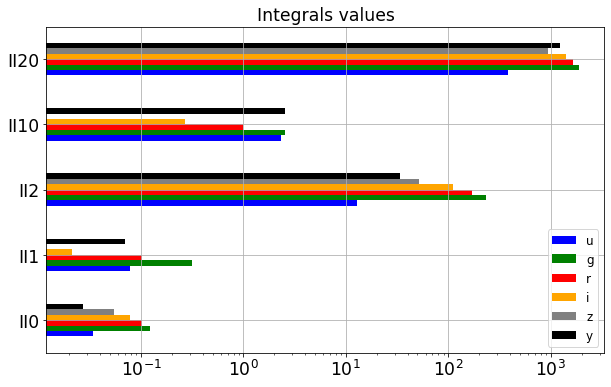

In [53]:
#my_colors = list(islice(cycle(['b', 'g', 'r', 'orange','grey','k']), None, len(df_IIstd_2)))
df_IIstd_2.plot.barh(log=True, figsize=(10,6),color=['b','g','r','orange','grey','k'],grid=True,title="Integrals values") 

## Calculate II differences

In [54]:
all_II_diff = []
for idx,z in enumerate(all_am):
    II_diff = all_df_IIobs[idx]-df_IIstd  
    all_II_diff.append(II_diff) 

In [55]:
all_II_div = []
for idx,z in enumerate(all_am):
    II_div = all_df_IIobs[idx]/df_IIstd  
    all_II_div.append(II_div) 

In [56]:
all_II_diff[15]

II0       II1        II2      II10       II20
0 -0.014692  0.009905  -5.621153  2.320439  -2.992605
1 -0.026603  0.190536 -51.441899  2.693925 -11.993482
2 -0.012920  0.089282 -21.064902  1.147862   5.195948
3 -0.005872  0.026282  -8.098218  0.383888   3.145789
4 -0.002969 -0.008280  -3.574148 -0.177362 -14.807694
5 -0.002402  0.034547  -2.042921  1.639650  36.615670

In [57]:
all_II_diff[7].iloc[5]["II0"]

-0.0010208297978710687

## Plot integral difference between observed and standard atmosphere

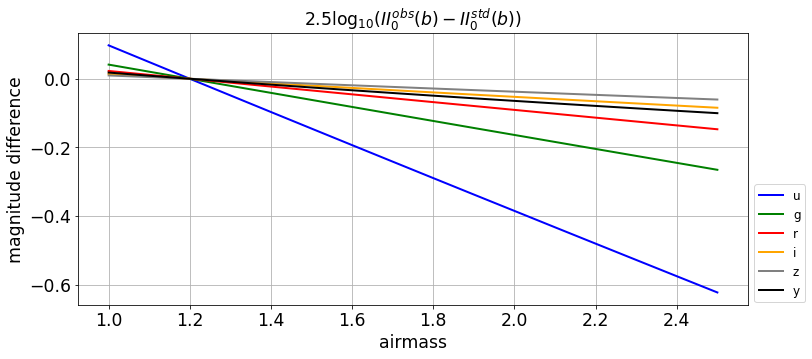

In [58]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
# loop on filters
for ifilt in range(NFILT): 
    the_div_mag = np.zeros(NAM)
    # loop on airmass to get the difference on II
    for idx,z in enumerate(all_am):
        the_div_mag[idx]= 2.5*np.log10(all_II_div[idx].iloc[ifilt]["II0"])
    ax.plot(all_am,the_div_mag,color=filter_color[ifilt],label=filter_tagnames[ifilt],lw=2)
ax.set_xlabel("airmass")
ax.set_ylabel("magnitude difference")
ax.set_title("$2.5 \log_{10} (II_0^{obs}(b)-II_0^{std}(b))$")
ax.legend(loc=(1.01, 0.01))
ax.grid()

- Magnitude corrections are of the order of 100 mmag, thus are huge. But what realu matters is the resolution on $\mathbb{I}_0^{obs}(b)$ 

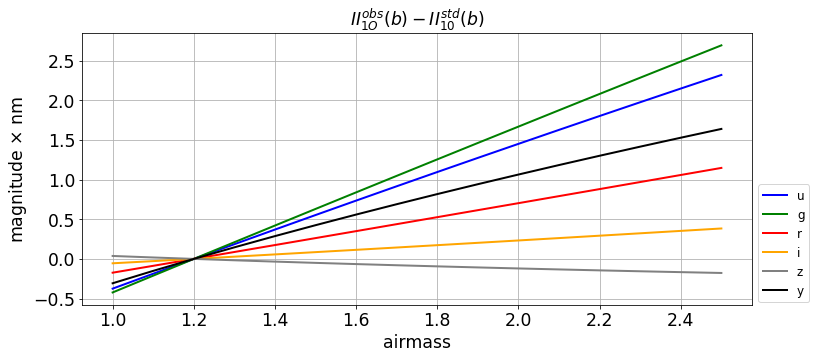

In [59]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
# loop on filters
for ifilt in range(NFILT): 
    the_diff = np.zeros(NAM)
    # loop on airmass to get the difference on II
    for idx,z in enumerate(all_am):
        the_diff[idx]=all_II_diff[idx].iloc[ifilt]["II10"]
    ax.plot(all_am,the_diff,color=filter_color[ifilt],label=filter_tagnames[ifilt],lw=2)
ax.set_xlabel("airmass")
ax.set_ylabel("magnitude $\\times$ nm")
ax.set_title("$II_{1O}^{obs}(b)-II_{10}^{std}(b)$")
ax.legend(loc=(1.01, 0.01))
ax.grid()

- $\mathbb{I}_{1O}^{obs}(b)-\mathbb{I}_{10}^{std}(b)$ in magnitude x nm
- It must be multiplied by $f^{\prime}(\lambda_b)$ in $nm^{-1}$

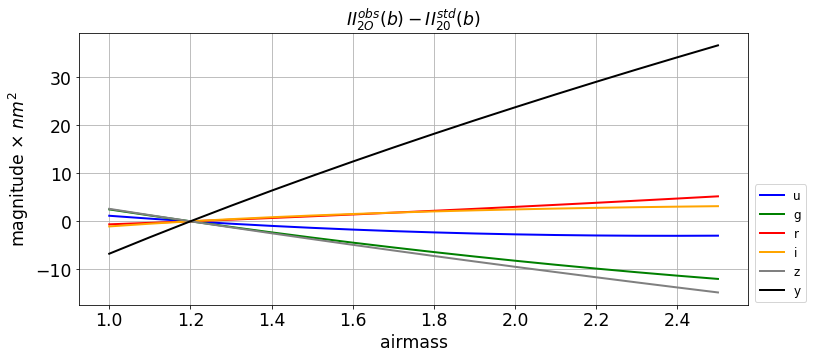

In [60]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
# loop on filters
for ifilt in range(NFILT): 
    the_diff = np.zeros(NAM)
    # loop on airmass to get the difference on II
    for idx,z in enumerate(all_am):
        the_diff[idx]=all_II_diff[idx].iloc[ifilt]["II20"]
    ax.plot(all_am,the_diff,color=filter_color[ifilt],label=filter_tagnames[ifilt],lw=2)
ax.set_xlabel("airmass")
ax.set_ylabel("magnitude $\\times \,\, nm^2$")
ax.set_title("$II_{2O}^{obs}(b)-II_{20}^{std}(b)$")
ax.legend(loc=(1.01, 0.01))
ax.grid()

- $\mathbb{I}_{1O}^{obs}(b)-\mathbb{I}_{10}^{std}(b)$ in magnitude x $nm^2$
- It must be multiplied by $f^{\prime\prime}(\lambda_b)$ in $nm^{-2}$

# SED

- Use SED sample from Lynne Jones
https://github.com/rhiannonlynne/photometry_sample

In [61]:
# this will contain attributes calculated for each SED
df_SED = pd.DataFrame(columns=["name","type"])

In [62]:
datadir = get_data_dir()
#sedDir = '/Users/lynnej/other_repos/photometry_sample'
sedDir = os.path.join(datadir,'photometry_sample')

sedtypes = ['galaxies', 'quasar', 'stars'] 
sedtypes_not_used = ['sn', 'photoZ_outliers', 'white_dwarf']
sedtypes = sedtypes + sedtypes_not_used

NSEDTYPES = len(sedtypes)

seds = {}
sedsfnu = {}
sedtypeslists = {}
count_sed =0

# loop on SED type
for idx,s in enumerate(sedtypes):
    sedtypelist = []
    # loop on object sed in SED type list
    filenames = os.listdir(os.path.join(sedDir, s))
    for f in filenames:
        name = f.replace('.dat', '').replace('.sed', '')
        
        if name == "m3.0Full":
            continue
            
        seds[name] = Sed()
        seds[name].readSED_flambda(os.path.join(sedDir, s, f))
        sedsfnu[name]= Sed()
    
        # save the name of the sed in the list
        sedtypelist.append(name) 
        df_SED.loc[count_sed] = [name,s]
        count_sed+=1
        
    # save the above list in a dictionary
    sedtypeslists[s] =  sedtypelist
        

In [63]:
df_SED=df_SED.set_index('name')
df_SED

type
name                               
Sa_template_norm           galaxies
Sdm_template_norm0         galaxies
Ell2_template_norm         galaxies
quasar                       quasar
km10_5250.fits_g45            stars
km10_4500.fits_g45            stars
km10_6000.fits_g45            stars
km10_7250.fits_g45            stars
km10_6500.fits_g45            stars
sn1a_10.0                        sn
sn1a_15.0                        sn
sn1a_20.0                        sn
xspec_173           photoZ_outliers
xspec_172           photoZ_outliers
xspec_90            photoZ_outliers
xspec_91            photoZ_outliers
xspec_176           photoZ_outliers
xspec_175           photoZ_outliers
wd_He_5500_80           white_dwarf
wd_H_5500_80            white_dwarf
wd_He_15000_80          white_dwarf
wd_H_50000_80           white_dwarf
wd_He_10000_80          white_dwarf
wd_H_100000_80          white_dwarf
wd_H_15000_80           white_dwarf

In [64]:
#list(seds.keys())

In [65]:
#sedtypeslists

In [66]:
NSED = len(list(seds.keys()))

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NSED)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSED), alpha=1)

In [67]:
# Redshift the quasar. Note repeat calls to this cell will stack, increasing the redshift multiple times.
z=1.5
seds['quasar'].redshiftSED(z)

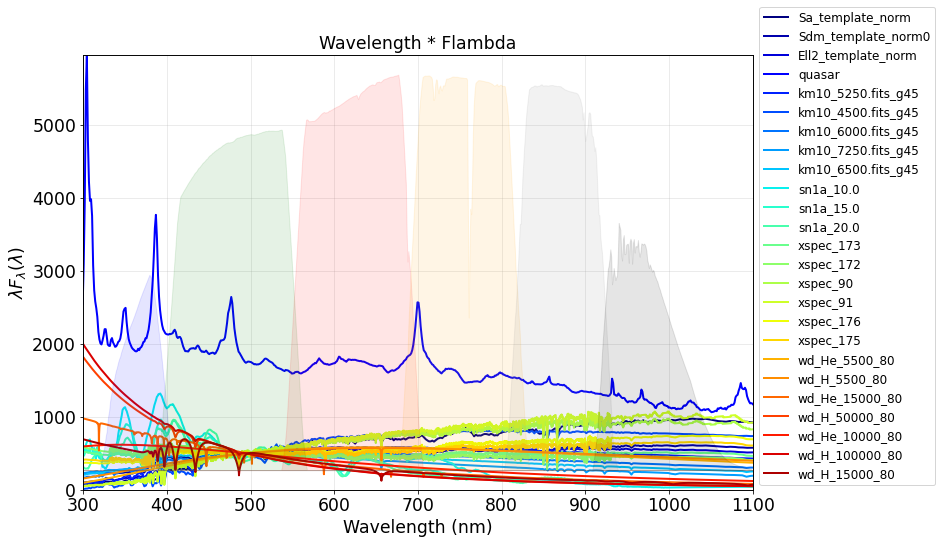

In [68]:
# Plot the seds
fig, ax = plt.subplots(1,1,figsize=(12,8))

sedmax=0
# loop on SED
for idx,n in enumerate(seds):
    ax.plot(seds[n].wavelen, seds[n].flambda * seds[n].wavelen, color=all_colors[idx],label=n,lw=2)
    
    fl = seds[n].flambda * seds[n].wavelen
    wav= seds[n].wavelen
    fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
    sedmax=max(sedmax,fl.max()) 
    
    
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)
ax.set_ylim(0, sedmax)
ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$\lambda F_\lambda(\lambda)$")
ax.set_title("Wavelength * Flambda")

ax2 = ax.twinx()
for ifilt in range(NFILT):
    tag="tot_"+filter_tagnames[ifilt]
    #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
    ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])

- m3 is a gmobular Cluster Messier 3 or NGC 5272

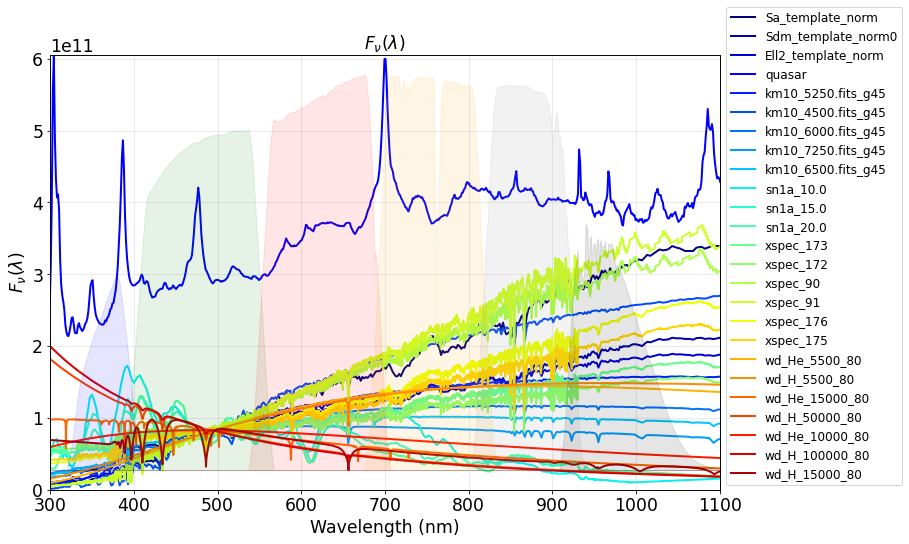

In [69]:
# Plot the seds
fig, ax = plt.subplots(1,1,figsize=(12,8))

# loop on SED
sedmax=0
for idx,name in enumerate(seds):
    wavel,fnu = seds[name].getSED_fnu()
    ax.plot(wavel, fnu, color=all_colors[idx],label=name,lw=2)
    
    
    fl = fnu
    wav= wavel
    fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
    sedmax=max(sedmax,fl.max()) 
    
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)
ax.set_ylim(0, sedmax)

ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$F_\\nu (\lambda)$")
ax.set_title("$F_\\nu (\lambda)$")

ax2 = ax.twinx()
for ifilt in range(NFILT):
    tag="tot_"+filter_tagnames[ifilt]
    #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
    ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])

In [70]:
sedtypeslists["galaxies"]

['Sa_template_norm', 'Sdm_template_norm0', 'Ell2_template_norm']

In [71]:
wav

array([ 300. ,  300.1,  300.2, ..., 1199.8, 1199.9, 1200. ])

In [72]:
np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]

array([   0,    1,    2, ..., 7998, 7999, 8000])

Text(0.5, 1.0, 'SED $\\lambda F_\\lambda$')

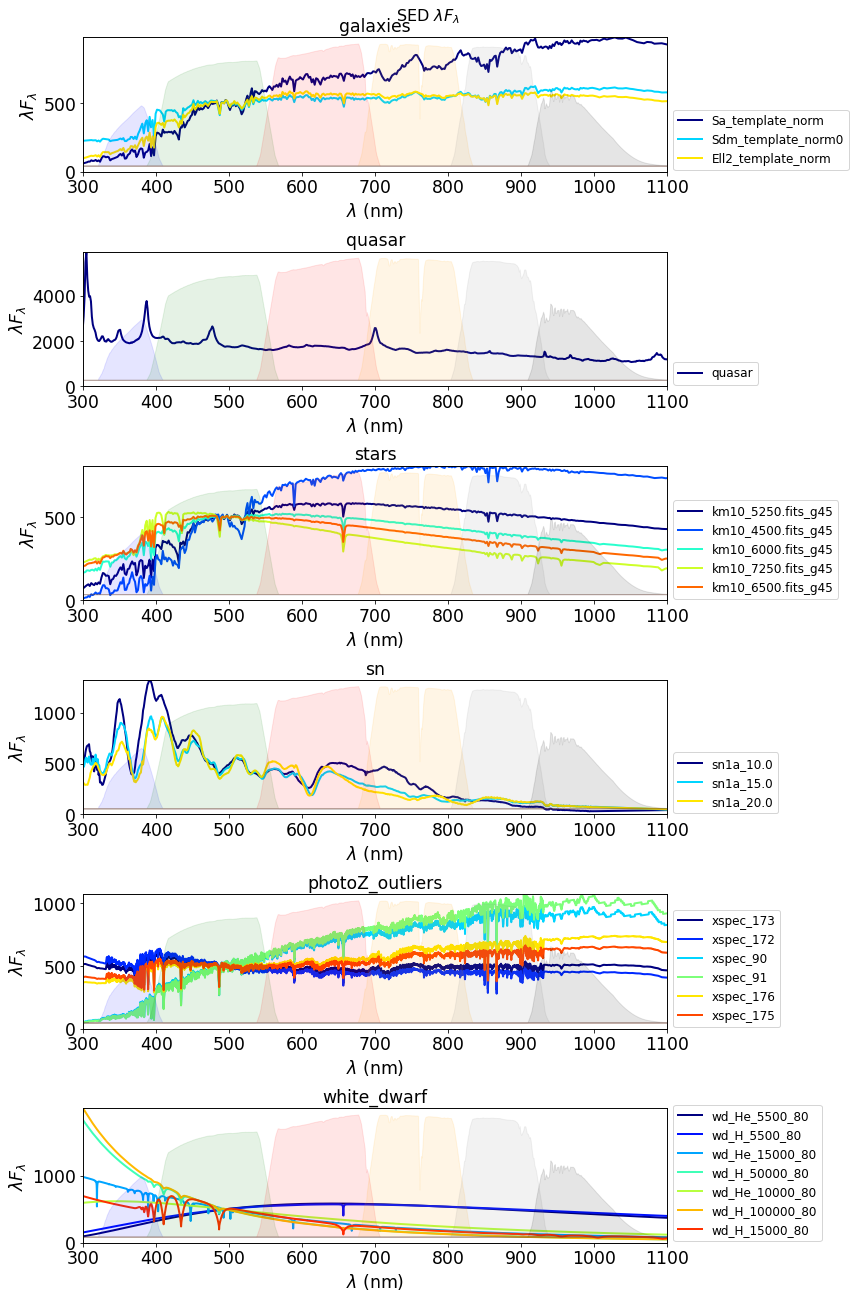

In [73]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))


# loop on all SED types
for idx,s in enumerate(sedtypes):
    
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    
    # loop on the SED of a given type
    sedmax=0
    for idx0,name in  enumerate(sednamelist):
        axs[idx].plot(seds[name].wavelen, seds[name].flambda * seds[name].wavelen, color=all_colors[idx0],label=name,lw=2)
        #compute SED max
        fl = seds[name].flambda * seds[name].wavelen
        wav= seds[name].wavelen
        fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
        sedmax=max(sedmax,fl.max()) 
    
    axs[idx].set_ylim(0,sedmax)
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$\lambda F_\lambda$")
    
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
    
plt.tight_layout()
plt.suptitle("SED $\\lambda F_\\lambda$",fontsize=16,y=1.0)

Text(0.5, 1.01, 'SED $F_\\nu$')

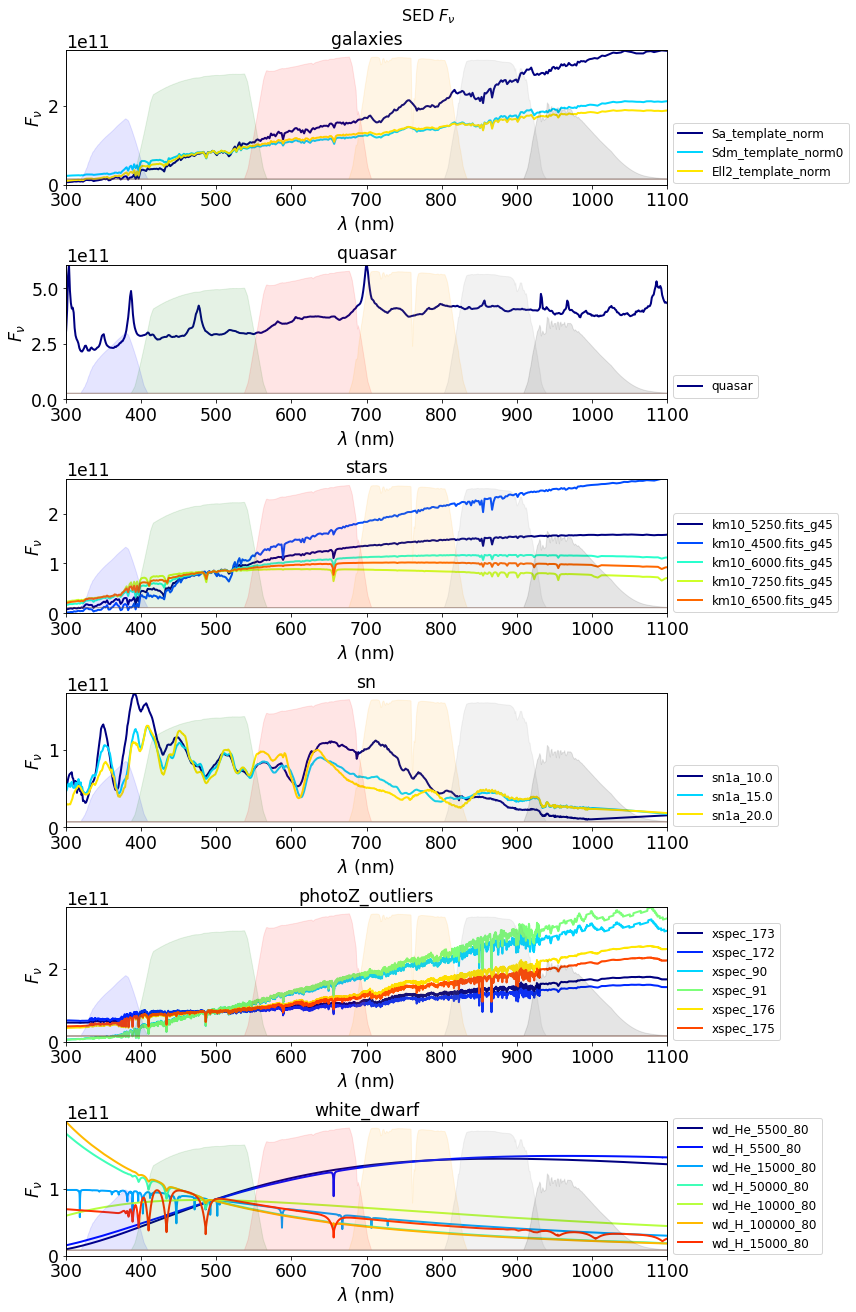

In [74]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))

# loop on SED types
for idx,s in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    
    sedmax=0
    # loop on objects in sedtypes
    for idx0,name in  enumerate(sednamelist):
        wavel,fnu = seds[name].getSED_fnu()
        axs[idx].plot(wavel, fnu , color=all_colors[idx0],label=name,lw=2)
        #compute SED max
        fl = fnu
        wav= wavel
        fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
        sedmax=max(sedmax,fl.max()) 
        
    axs[idx].set_ylim(0,sedmax)
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$F_\\nu$")
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
    
plt.tight_layout()
plt.suptitle("SED $F_\\nu$",fontsize=16,y=1.01)

Text(0.5, 1.01, 'SED $f^\\prime_\\nu$')

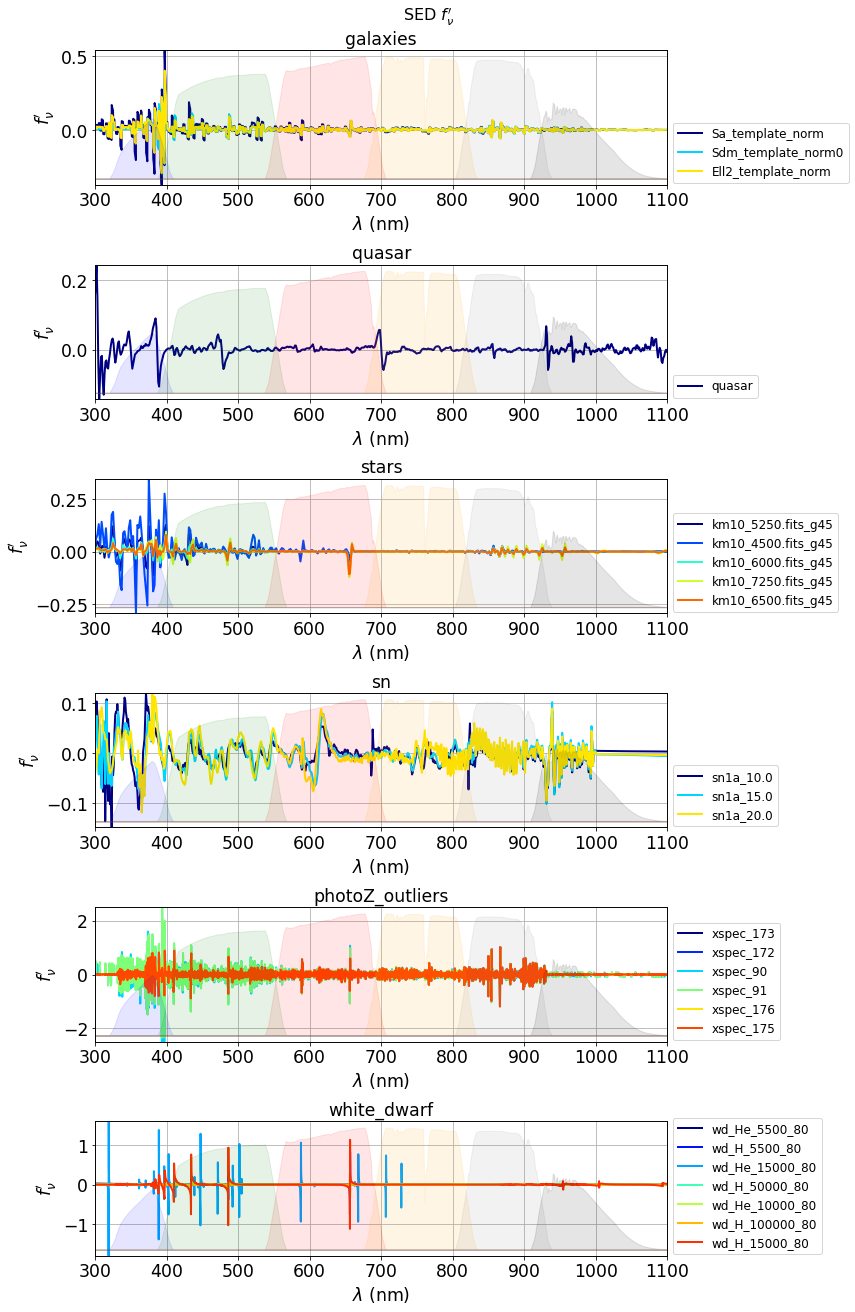

In [75]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))


# loop on SED types
for idx,s in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    
    sedmin=0
    sedmax=0
    
    #loop on object in sedtype
    for idx0,name in  enumerate(sednamelist):
        wavel,fnu = seds[name].getSED_fnu()
        x=wavel
        y = fnu
        fnup=np.gradient(y, x)
        fratio = fnup/fnu
        axs[idx].plot(wavel, fratio , color=all_colors[idx0],label=name,lw=2)
        
        #compute SED max
        fl = fratio
        wav= wavel
        fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
        sedmax=max(sedmax,fl.max()) 
        sedmin=min(sedmin,fl.min()) 
        
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_ylim(sedmin,sedmax)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$f^\prime_\\nu$")
    axs[idx].grid()
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
plt.tight_layout()
plt.suptitle("SED $f^\prime_\\nu$",fontsize=16,y=1.01)

Text(0.5, 1.01, 'SED $f^{\\prime\\prime}_\\nu$')

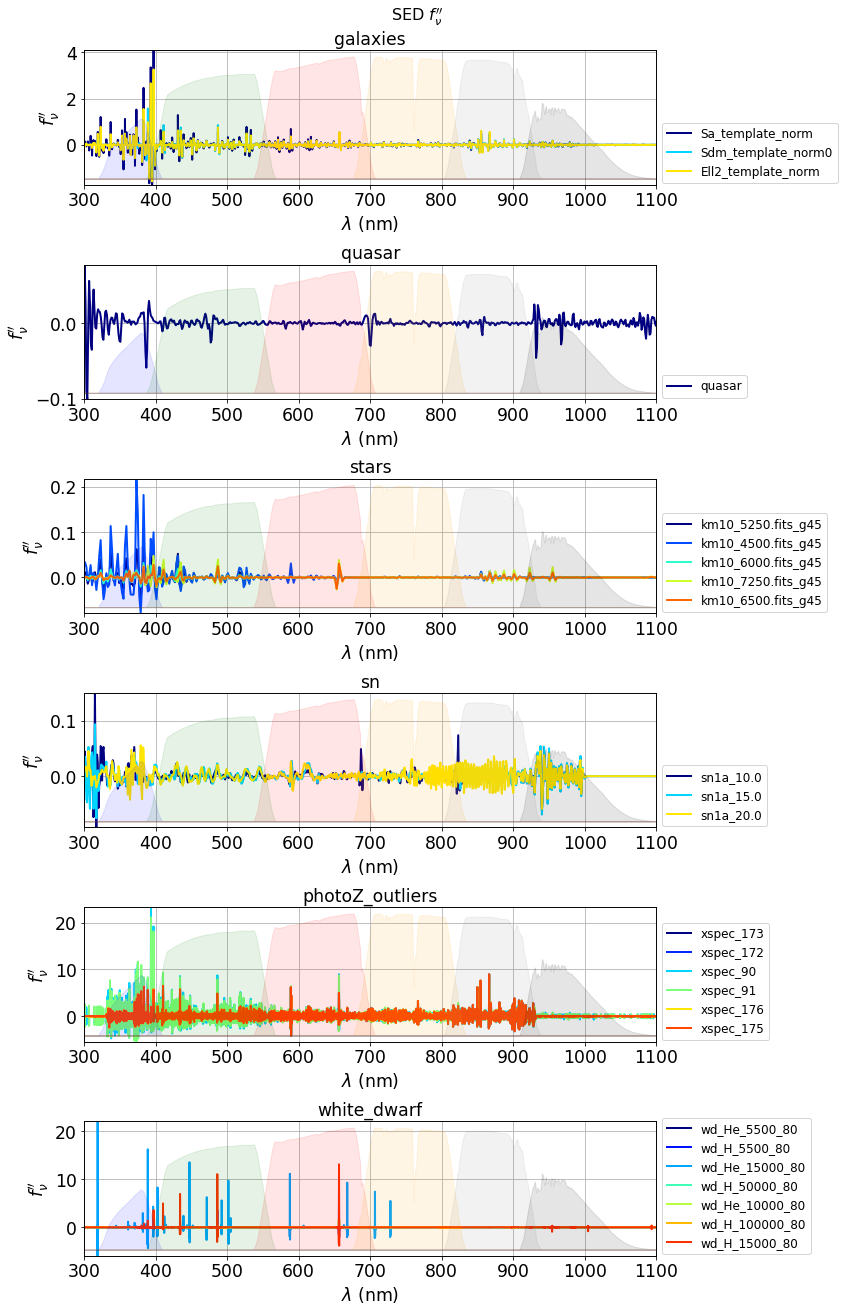

In [76]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))

for idx,s in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    
    
    #loop on objects in sed type list
    sedmin=0
    sedmax=0
    for idx0,name in  enumerate(sednamelist):
        wavel,fnu = seds[name].getSED_fnu()
        x=wavel
        y = fnu
        fnup=np.gradient(y, x)
        fnupp = np.gradient(fnup,x)
        fratio = fnupp/fnu
        axs[idx].plot(wavel, fratio , color=all_colors[idx0],label=name,lw=2)
        
        #compute SED max
        fl = fratio
        wav= wavel
        fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
        sedmax=max(sedmax,fl.max()) 
        sedmin=min(sedmin,fl.min()) 
        
        
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_ylim(sedmin,sedmax)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$f^{\prime\prime}_\\nu$")
    axs[idx].grid()
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
plt.tight_layout()
plt.suptitle("SED $f^{\prime\prime}_\\nu$",fontsize=16,y=1.01)

# Filtering the SED

In [77]:
def smooth_data_convolve_my_average(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

    # The "my_average" part: shrinks the averaging window on the side that 
    # reaches beyond the data, keeps the other side the same size as given 
    # by "span"
    re[0] = np.average(arr[:span])
    for i in range(1, span + 1):
        re[i] = np.average(arr[:i + span])
        re[-i] = np.average(arr[-i - span:])
    return re

def smooth_data_np_average(arr, span):  # my original, naive approach
    return [np.average(arr[val - span:val + span + 1]) for val in range(len(arr))]

def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

def smooth_data_np_cumsum_my_average(arr, span):
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[2 * span:] - cumsum_vec[:-2 * span]) / (2 * span)

    # The "my_average" part again. Slightly different to before, because the
    # moving average from cumsum is shorter than the input and needs to be padded
    front, back = [np.average(arr[:span])], []
    for i in range(1, span):
        front.append(np.average(arr[:i + span]))
        back.insert(0, np.average(arr[-i - span:]))
    back.insert(0, np.average(arr[-2 * span:]))
    return np.concatenate((front, moving_average, back))

def smooth_data_lowess(arr, span):
    x = np.linspace(0, 1, len(arr))
    return sm.nonparametric.lowess(arr, x, frac=(5*span / len(arr)), return_sorted=False)

def smooth_data_kernel_regression(arr, span):
    # "span" smoothing parameter is ignored. If you know how to 
    # incorporate that with kernel regression, please comment below.
    kr = KernelReg(arr, np.linspace(0, 1, len(arr)), 'c')
    return kr.fit()[0]

def smooth_data_savgol_0(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 0)

def smooth_data_savgol_1(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 1)

def smooth_data_savgol_2(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 2)

def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)


In [78]:
# filtering width in nm
span=150

Text(0.5, 1.01, 'Filtered SED $F_\\nu$')

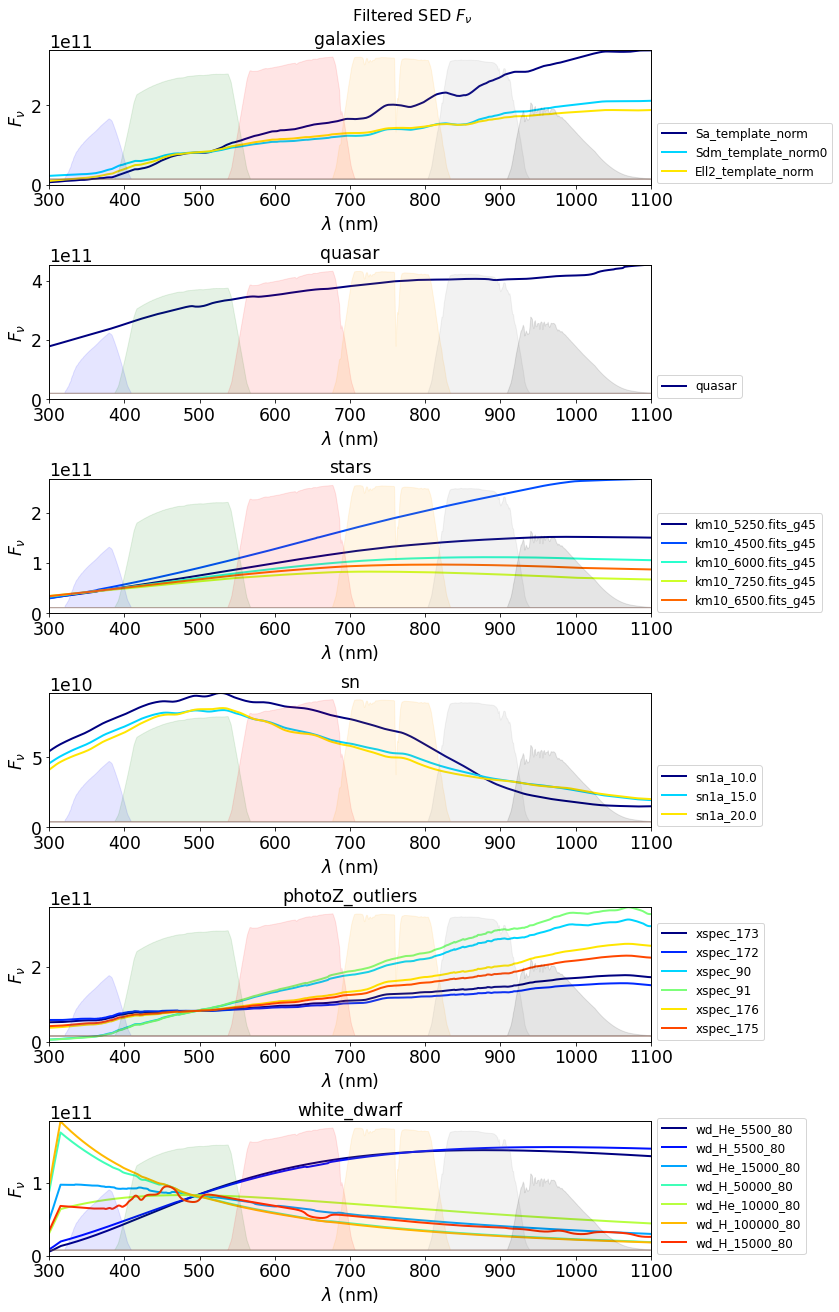

In [79]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))

for idx,s in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    
    
    sedmin=0
    sedmax=0
    for idx0,name in  enumerate(sednamelist):
        wavel,fnu = seds[name].getSED_fnu()
        
        fnu_filtered = smooth_data_np_convolve(fnu, span)
        
        axs[idx].plot(wavel, fnu_filtered , color=all_colors[idx0],label=name,lw=2)
        
        #compute SED max
        fl = fnu_filtered
        wav= wavel
        fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
        sedmax=max(sedmax,fl.max()) 
        sedmin=min(sedmin,fl.min()) 
        
        
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_ylim(0,sedmax)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$F_\\nu$")
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
    
plt.tight_layout()
plt.suptitle("Filtered SED $F_\\nu$",fontsize=16,y=1.01)

Text(0.5, 1.01, 'Filtered SED $f^\\prime_\\nu$')

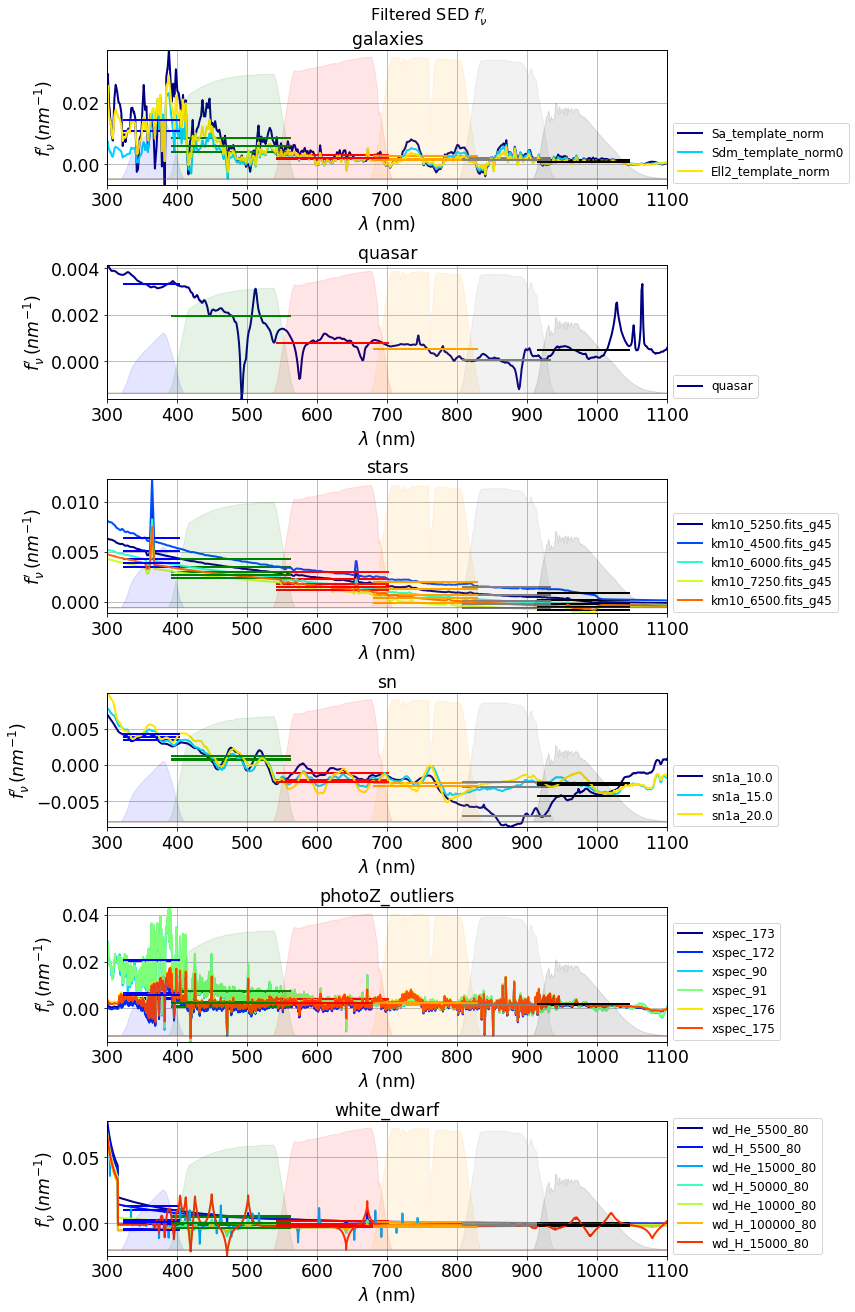

In [80]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))

df_fp = pd.DataFrame(columns=["fp_u","fp_g","fp_r","fp_i","fp_z","fp_y"])

for idx,s in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    
    sedmin=0
    sedmax=0
    # loop on object in sed type
    for idx0,name in  enumerate(sednamelist):
        wavel,fnu = seds[name].getSED_fnu()
        fnu_filtered = smooth_data_np_convolve(fnu, span)
        x=wavel
        y = fnu_filtered
        fnup=np.gradient(y, x)
        fratio = fnup/fnu_filtered
        axs[idx].plot(wavel, fratio , color=all_colors[idx0],label=name,lw=2)
        
        #compute SED max
        fl = fratio
        wav= wavel
        fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
        sedmax=max(sedmax,fl.max()) 
        sedmin=min(sedmin,fl.min()) 
        
        
        # average fp
        fp_filters = ComputeAverage(x,fratio,df_std)
        for ifilt in range(NFILT):
            axs[idx].plot([FILTERWL[ifilt,0],FILTERWL[ifilt,1]],[fp_filters[ifilt],fp_filters[ifilt]],color=filter_color[ifilt],lw=2)
        df_fp.loc[name] = fp_filters     
        
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_ylim(sedmin,sedmax)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$f^\prime_\\nu \, (nm^{-1})$")
    axs[idx].grid()
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
plt.tight_layout()
plt.suptitle("Filtered SED $f^\prime_\\nu$",fontsize=16,y=1.01)

In [81]:
df_fp

fp_u      fp_g      fp_r      fp_i      fp_z      fp_y
Sa_template_norm    0.014301  0.008538  0.002845  0.002649  0.002082  0.001375
Sdm_template_norm0  0.010849  0.003984  0.001751  0.001752  0.001762  0.001118
Ell2_template_norm  0.014335  0.005998  0.001871  0.001270  0.001196  0.000739
quasar              0.003327  0.001946  0.000775  0.000516  0.000041  0.000484
km10_5250.fits_g45  0.005114  0.003496  0.002284  0.001228  0.000612  0.000162
km10_4500.fits_g45  0.006373  0.004270  0.002940  0.001961  0.001412  0.000867
km10_6000.fits_g45  0.004269  0.002958  0.001740  0.000667  0.000075 -0.000287
km10_7250.fits_g45  0.003432  0.002357  0.001124 -0.000106 -0.000626 -0.000824
km10_6500.fits_g45  0.003867  0.002682  0.001450  0.000342 -0.000216 -0.000517
sn1a_10.0           0.003489  0.000849 -0.001153 -0.002956 -0.007070 -0.004344
sn1a_15.0           0.003938  0.000744 -0.002065 -0.002479 -0.003088 -0.002754
sn1a_20.0           0.004263  0.001231 -0.002352 -0.002939 -0.002310 -0.002469
xspec_173           0.004544  0.001143  0.001474  0.001795  0.001066  0.001464
xspec_172           0.003923  0.000696  0.001168  0.001568  0.000896  0.001328
xspec_90            0.020085  0.007136  0.003539  0.002193  0.001736  0.001329
xspec_91            0.020612  0.007490  0.003794  0.002361  0.001874  0.001416
xspec_176           0.006400  0.002485  0.002389  0.002475  0.001574  0.001868
xspec_175           0.005782  0.002038  0.002085  0.002249  0.001406  0.001734
wd_He_5500_80       0.012820  0.005620  0.001920  0.000607  0.000040 -0.000243
wd_H_5500_80        0.009873  0.004860  0.001937  0.000783  0.000259 -0.000006
wd_He_15000_80     -0.000834 -0.001312 -0.001939 -0.001700 -0.001665 -0.001558
wd_H_50000_80      -0.004507 -0.003359 -0.002985 -0.002476 -0.002161 -0.001934
wd_He_10000_80      0.002240  0.000138 -0.000867 -0.001139 -0.001207 -0.001209
wd_H_100000_80     -0.004913 -0.003766 -0.003051 -0.002521 -0.002193 -0.001965
wd_H_15000_80       0.000535  0.000445 -0.002339 -0.001910 -0.001608 -0.001614

In [82]:
df_fp.describe()

fp_u       fp_g       fp_r       fp_i       fp_z       fp_y
count  25.000000  25.000000  25.000000  25.000000  25.000000  25.000000
mean    0.006165   0.002507   0.000733   0.000247  -0.000245  -0.000234
std     0.006446   0.003082   0.002134   0.001919   0.002085   0.001649
min    -0.004913  -0.003766  -0.003051  -0.002956  -0.007070  -0.004344
25%     0.003432   0.000744  -0.001153  -0.001700  -0.001608  -0.001558
50%     0.004269   0.002357   0.001474   0.000667   0.000075  -0.000006
75%     0.009873   0.004270   0.002085   0.001795   0.001406   0.001328
max     0.020612   0.008538   0.003794   0.002649   0.002082   0.001868

<AxesSubplot:title={'center':'$f_\\nu^{\\prime}$'}, ylabel='$f^{\\prime}_\\nu \\quad (nm^{-1})$'>

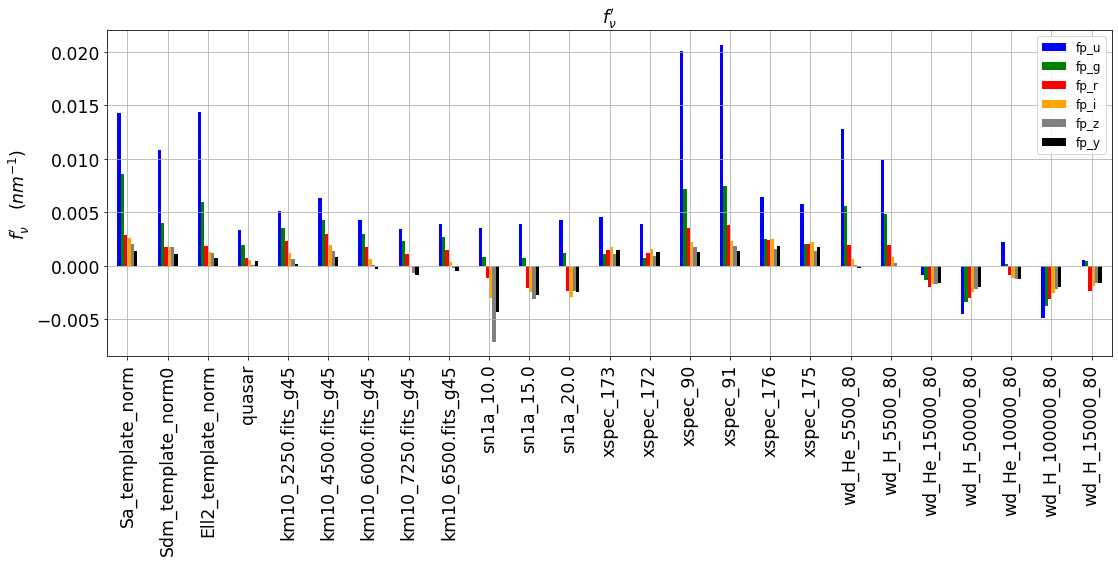

In [83]:
my_colors = list(islice(cycle(['b', 'g', 'r', 'orange','grey','k']), None, len(df_fp)))
df_fp.plot.bar(figsize=(18,6),ylabel="$f^{\prime}_\\nu \quad (nm^{-1})$",grid=True,color=my_colors,title="$f_\\nu^{\prime}$")

Text(0.5, 1.01, 'Filtered SED $f^{\\prime\\prime}_\\nu$')

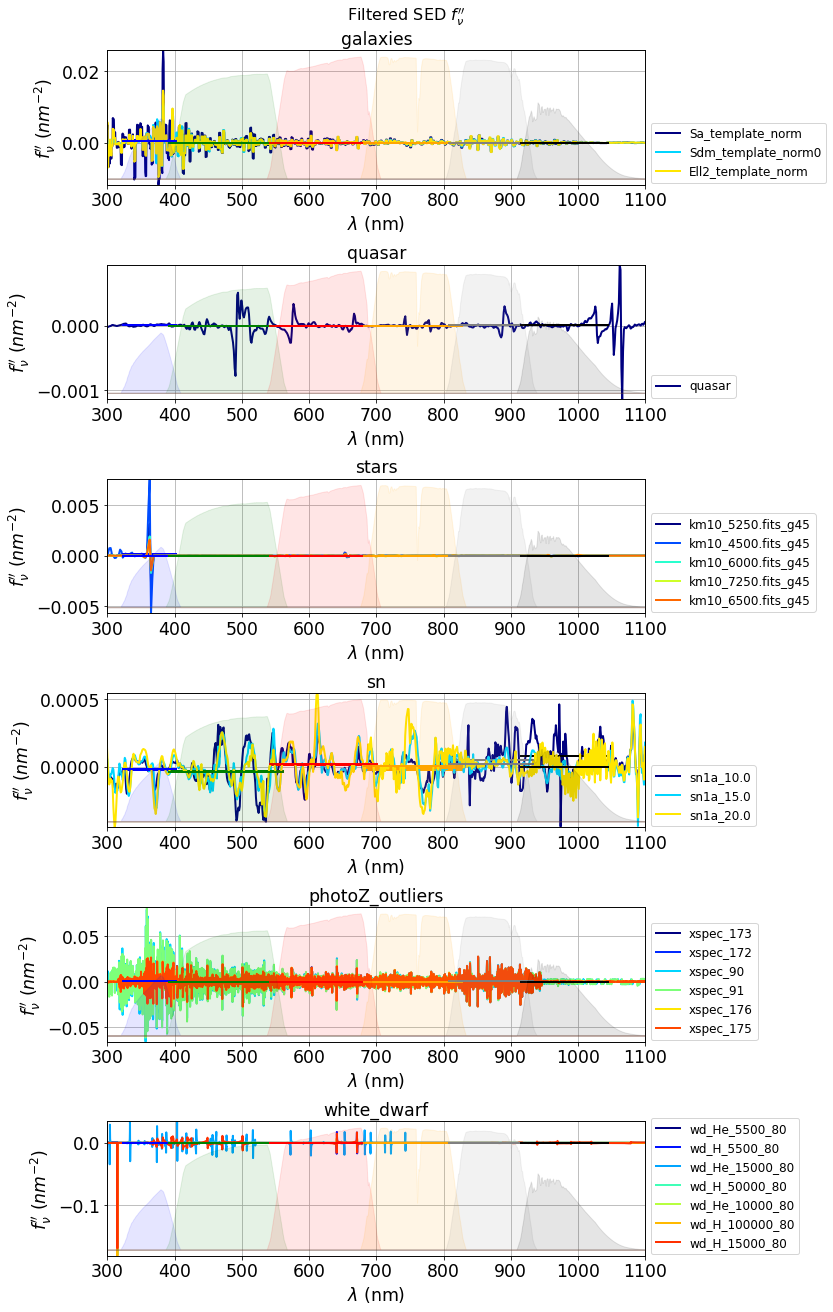

In [84]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))

df_fpp = pd.DataFrame(columns=["fpp_u","fpp_g","fpp_r","fpp_i","fpp_z","fpp_y"])

# loop on sedtypes
for idx,s in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    
    #loop on object in sedypes
    sedmax=0
    sedmin=0
    
    for idx0,name in  enumerate(sednamelist):
        wavel,fnu = seds[name].getSED_fnu()
        fnu_filtered = smooth_data_np_convolve(fnu, span)
        x=wavel
        y = fnu_filtered
        fnup=np.gradient(y, x)
        fnupp = np.gradient(fnup,x)
        fratio = fnupp/fnu
        axs[idx].plot(wavel, fratio , color=all_colors[idx0],label=name,lw=2)
        
        #compute SED max
        fl = fratio
        wav= wavel
        fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
        sedmax=max(sedmax,fl.max()) 
        sedmin=min(sedmin,fl.min()) 
        
        
        # average fpp
        fpp_filters = ComputeAverage(x,fratio,df_std)
        for ifilt in range(NFILT):
            axs[idx].plot([FILTERWL[ifilt,0],FILTERWL[ifilt,1]],[fpp_filters[ifilt],fpp_filters[ifilt]],color=filter_color[ifilt],lw=2)
        df_fpp.loc[name] = fpp_filters   
        
        
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_ylim(sedmin,sedmax)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$f^{\prime\prime}_\\nu \,\, (nm^{-2})$")
    axs[idx].grid()
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
plt.tight_layout()
plt.suptitle("Filtered SED $f^{\prime\prime}_\\nu$",fontsize=16,y=1.01)

In [85]:
df_fpp

fpp_u         fpp_g         fpp_r         fpp_i  \
Sa_template_norm    8.142394e-04  2.715636e-05 -1.158712e-05  2.409259e-05   
Sdm_template_norm0  3.800839e-04 -1.521520e-05 -8.983509e-06  1.283245e-05   
Ell2_template_norm  4.622565e-04 -2.029196e-05 -1.319428e-05  4.935868e-06   
quasar              4.492500e-06 -7.865819e-06 -3.650512e-06 -5.165741e-06   
km10_5250.fits_g45  3.102382e-05  2.230997e-06  6.604832e-07 -5.416368e-06   
km10_4500.fits_g45  1.615988e-04  8.030224e-06  4.693720e-06 -1.820240e-06   
km10_6000.fits_g45  9.306161e-06 -4.389912e-08 -2.468966e-06 -6.134886e-06   
km10_7250.fits_g45 -2.652338e-07 -2.080088e-06 -5.027089e-06 -6.768424e-06   
km10_6500.fits_g45  4.111524e-06 -1.018175e-06 -3.816319e-06 -6.290472e-06   
sn1a_10.0          -1.653642e-05 -3.515256e-05  1.021431e-05 -2.180018e-05   
sn1a_15.0          -2.249601e-05 -3.461403e-05  1.558809e-05 -8.946374e-06   
sn1a_20.0          -1.767402e-05 -3.822638e-05  2.281048e-05  7.763345e-06   
xspec_173           7.075463e-04 -1.682422e-05 -7.313526e-05 -1.754921e-05   
xspec_172           7.037505e-04 -2.104487e-05 -6.257802e-05 -2.336341e-05   
xspec_90            5.707545e-04  1.234567e-04  8.586249e-05  1.292307e-04   
xspec_91            5.709291e-04  6.886307e-05  6.252888e-05  1.034372e-04   
xspec_176           7.260221e-04 -8.170027e-06 -6.641587e-05 -1.731979e-05   
xspec_175           7.142898e-04 -3.805054e-06 -6.370845e-05 -1.293684e-05   
wd_He_5500_80       6.203542e-05 -7.914307e-06 -1.051983e-05 -6.102236e-06   
wd_H_5500_80        3.990113e-05  3.003546e-05 -5.497655e-06 -5.805220e-06   
wd_He_15000_80     -3.196724e-05  1.184842e-05 -4.285487e-05  9.240007e-05   
wd_H_50000_80       4.554799e-05  4.664827e-06  2.625853e-05  8.299696e-06   
wd_He_10000_80     -2.701871e-05 -1.164601e-05 -2.619536e-06  4.022574e-07   
wd_H_100000_80      4.233044e-05  1.107338e-05  2.769871e-05  8.417947e-06   
wd_H_15000_80       2.703760e-04 -1.307615e-05  1.347041e-05 -1.817227e-06   

                           fpp_z         fpp_y  
Sa_template_norm   -7.764135e-07  3.499770e-09  
Sdm_template_norm0  9.148696e-07 -5.461987e-06  
Ell2_template_norm  3.475938e-07 -7.477426e-06  
quasar              1.119747e-06  6.153906e-06  
km10_5250.fits_g45 -3.485881e-06 -4.936044e-06  
km10_4500.fits_g45 -2.019566e-06 -8.763683e-06  
km10_6000.fits_g45 -3.762137e-06 -2.095557e-06  
km10_7250.fits_g45 -2.767446e-06  2.220246e-06  
km10_6500.fits_g45 -3.529467e-06 -4.138012e-07  
sn1a_10.0           5.047430e-05  8.055455e-05  
sn1a_15.0           1.988143e-05  5.871634e-07  
sn1a_20.0           1.944145e-05  1.146876e-07  
xspec_173           2.478102e-04  3.327674e-05  
xspec_172           2.534890e-04  2.477973e-05  
xspec_90            7.385480e-05  1.872936e-04  
xspec_91            1.077981e-04  2.010626e-04  
xspec_176           2.524249e-04  2.503169e-05  
xspec_175           2.443427e-04  3.070213e-05  
wd_He_5500_80      -3.458231e-06 -2.035591e-06  
wd_H_5500_80       -3.622149e-06 -1.294959e-06  
wd_He_15000_80      3.917604e-06  3.248244e-06  
wd_H_50000_80       8.115440e-06  5.724702e-06  
wd_He_10000_80      1.247884e-06  1.631301e-06  
wd_H_100000_80      7.244111e-06  4.047826e-06  
wd_H_15000_80      -7.949908e-06  3.175081e-05

In [86]:
df_fpp.describe()

fpp_u      fpp_g      fpp_r      fpp_i      fpp_z      fpp_y
count  25.000000  25.000000  25.000000  25.000000  25.000000  25.000000
mean    0.000248   0.000002  -0.000004   0.000010   0.000050   0.000024
std     0.000308   0.000034   0.000037   0.000039   0.000093   0.000055
min    -0.000032  -0.000038  -0.000073  -0.000023  -0.000008  -0.000009
25%     0.000004  -0.000015  -0.000012  -0.000007  -0.000003  -0.000001
50%     0.000046  -0.000004  -0.000004  -0.000005   0.000001   0.000002
75%     0.000571   0.000008   0.000013   0.000008   0.000050   0.000025
max     0.000814   0.000123   0.000086   0.000129   0.000253   0.000201

<AxesSubplot:title={'center':'$f_\\nu^{\\prime\\prime}$'}, ylabel='$f^{\\prime\\prime}_\\nu \\quad (nm^{-2})$'>

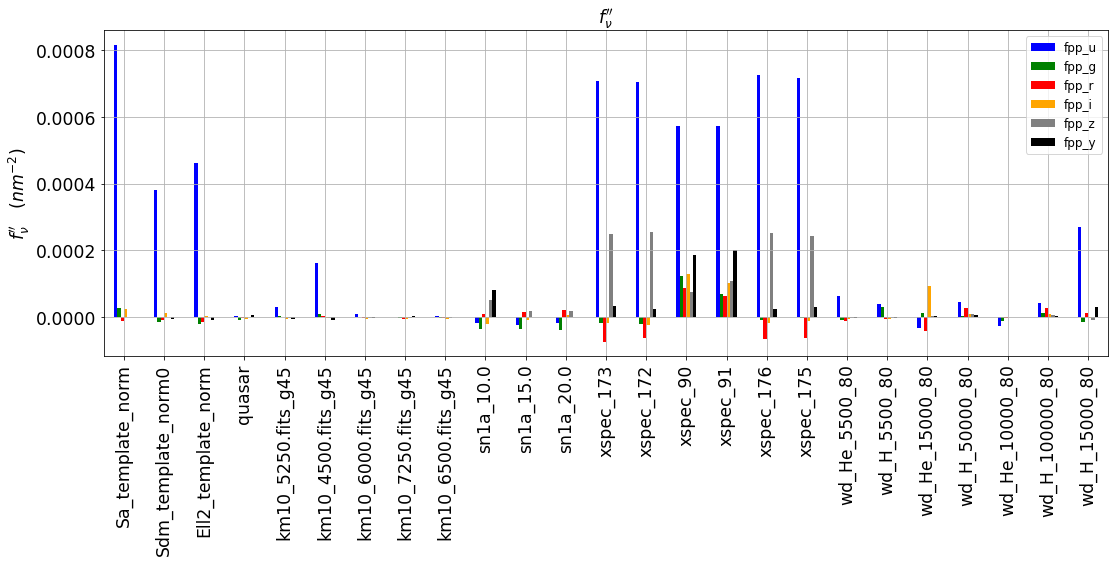

In [87]:
my_colors = list(islice(cycle(['b', 'g', 'r', 'orange','grey','k']), None, len(df_fpp)))
df_fpp.plot.bar(figsize=(18,6),ylabel="$f^{\prime\prime}_\\nu \quad (nm^{-2})$",grid=True,color=my_colors,title="$f_\\nu^{\prime\prime}$")

## Merge the three dataframe

In [88]:
df_SED_infos=pd.concat([df_SED,df_fp,df_fpp],axis=1)

In [89]:
df_SED_infos

type      fp_u      fp_g      fp_r      fp_i  \
Sa_template_norm           galaxies  0.014301  0.008538  0.002845  0.002649   
Sdm_template_norm0         galaxies  0.010849  0.003984  0.001751  0.001752   
Ell2_template_norm         galaxies  0.014335  0.005998  0.001871  0.001270   
quasar                       quasar  0.003327  0.001946  0.000775  0.000516   
km10_5250.fits_g45            stars  0.005114  0.003496  0.002284  0.001228   
km10_4500.fits_g45            stars  0.006373  0.004270  0.002940  0.001961   
km10_6000.fits_g45            stars  0.004269  0.002958  0.001740  0.000667   
km10_7250.fits_g45            stars  0.003432  0.002357  0.001124 -0.000106   
km10_6500.fits_g45            stars  0.003867  0.002682  0.001450  0.000342   
sn1a_10.0                        sn  0.003489  0.000849 -0.001153 -0.002956   
sn1a_15.0                        sn  0.003938  0.000744 -0.002065 -0.002479   
sn1a_20.0                        sn  0.004263  0.001231 -0.002352 -0.002939   
xspec_173           photoZ_outliers  0.004544  0.001143  0.001474  0.001795   
xspec_172           photoZ_outliers  0.003923  0.000696  0.001168  0.001568   
xspec_90            photoZ_outliers  0.020085  0.007136  0.003539  0.002193   
xspec_91            photoZ_outliers  0.020612  0.007490  0.003794  0.002361   
xspec_176           photoZ_outliers  0.006400  0.002485  0.002389  0.002475   
xspec_175           photoZ_outliers  0.005782  0.002038  0.002085  0.002249   
wd_He_5500_80           white_dwarf  0.012820  0.005620  0.001920  0.000607   
wd_H_5500_80            white_dwarf  0.009873  0.004860  0.001937  0.000783   
wd_He_15000_80          white_dwarf -0.000834 -0.001312 -0.001939 -0.001700   
wd_H_50000_80           white_dwarf -0.004507 -0.003359 -0.002985 -0.002476   
wd_He_10000_80          white_dwarf  0.002240  0.000138 -0.000867 -0.001139   
wd_H_100000_80          white_dwarf -0.004913 -0.003766 -0.003051 -0.002521   
wd_H_15000_80           white_dwarf  0.000535  0.000445 -0.002339 -0.001910   

                        fp_z      fp_y         fpp_u         fpp_g  \
Sa_template_norm    0.002082  0.001375  8.142394e-04  2.715636e-05   
Sdm_template_norm0  0.001762  0.001118  3.800839e-04 -1.521520e-05   
Ell2_template_norm  0.001196  0.000739  4.622565e-04 -2.029196e-05   
quasar              0.000041  0.000484  4.492500e-06 -7.865819e-06   
km10_5250.fits_g45  0.000612  0.000162  3.102382e-05  2.230997e-06   
km10_4500.fits_g45  0.001412  0.000867  1.615988e-04  8.030224e-06   
km10_6000.fits_g45  0.000075 -0.000287  9.306161e-06 -4.389912e-08   
km10_7250.fits_g45 -0.000626 -0.000824 -2.652338e-07 -2.080088e-06   
km10_6500.fits_g45 -0.000216 -0.000517  4.111524e-06 -1.018175e-06   
sn1a_10.0          -0.007070 -0.004344 -1.653642e-05 -3.515256e-05   
sn1a_15.0          -0.003088 -0.002754 -2.249601e-05 -3.461403e-05   
sn1a_20.0          -0.002310 -0.002469 -1.767402e-05 -3.822638e-05   
xspec_173           0.001066  0.001464  7.075463e-04 -1.682422e-05   
xspec_172           0.000896  0.001328  7.037505e-04 -2.104487e-05   
xspec_90            0.001736  0.001329  5.707545e-04  1.234567e-04   
xspec_91            0.001874  0.001416  5.709291e-04  6.886307e-05   
xspec_176           0.001574  0.001868  7.260221e-04 -8.170027e-06   
xspec_175           0.001406  0.001734  7.142898e-04 -3.805054e-06   
wd_He_5500_80       0.000040 -0.000243  6.203542e-05 -7.914307e-06   
wd_H_5500_80        0.000259 -0.000006  3.990113e-05  3.003546e-05   
wd_He_15000_80     -0.001665 -0.001558 -3.196724e-05  1.184842e-05   
wd_H_50000_80      -0.002161 -0.001934  4.554799e-05  4.664827e-06   
wd_He_10000_80     -0.001207 -0.001209 -2.701871e-05 -1.164601e-05   
wd_H_100000_80     -0.002193 -0.001965  4.233044e-05  1.107338e-05   
wd_H_15000_80      -0.001608 -0.001614  2.703760e-04 -1.307615e-05   

                           fpp_r         fpp_i         fpp_z         fpp_y  
Sa_template_norm   -1.158712e-05  2.409259e-05 -7.764135e-07  3.499770e-09  
S

# Photometric correction - Color effect vs airmass

In [90]:
all_II_diff[1]

II0       II1       II2      II10      II20
0  0.001542 -0.002999  0.603253 -0.186876  0.551149
1  0.002351 -0.020378  4.595386 -0.211249  1.216244
2  0.001074 -0.007897  1.755751 -0.087062 -0.323404
3  0.000494 -0.002064  0.661482 -0.027834 -0.502608
4  0.000244  0.000925  0.301528  0.018177  1.283181
5  0.000224 -0.003566  0.184677 -0.150882 -3.323101

## Photometric corretion with $f_\nu^\prime$ only

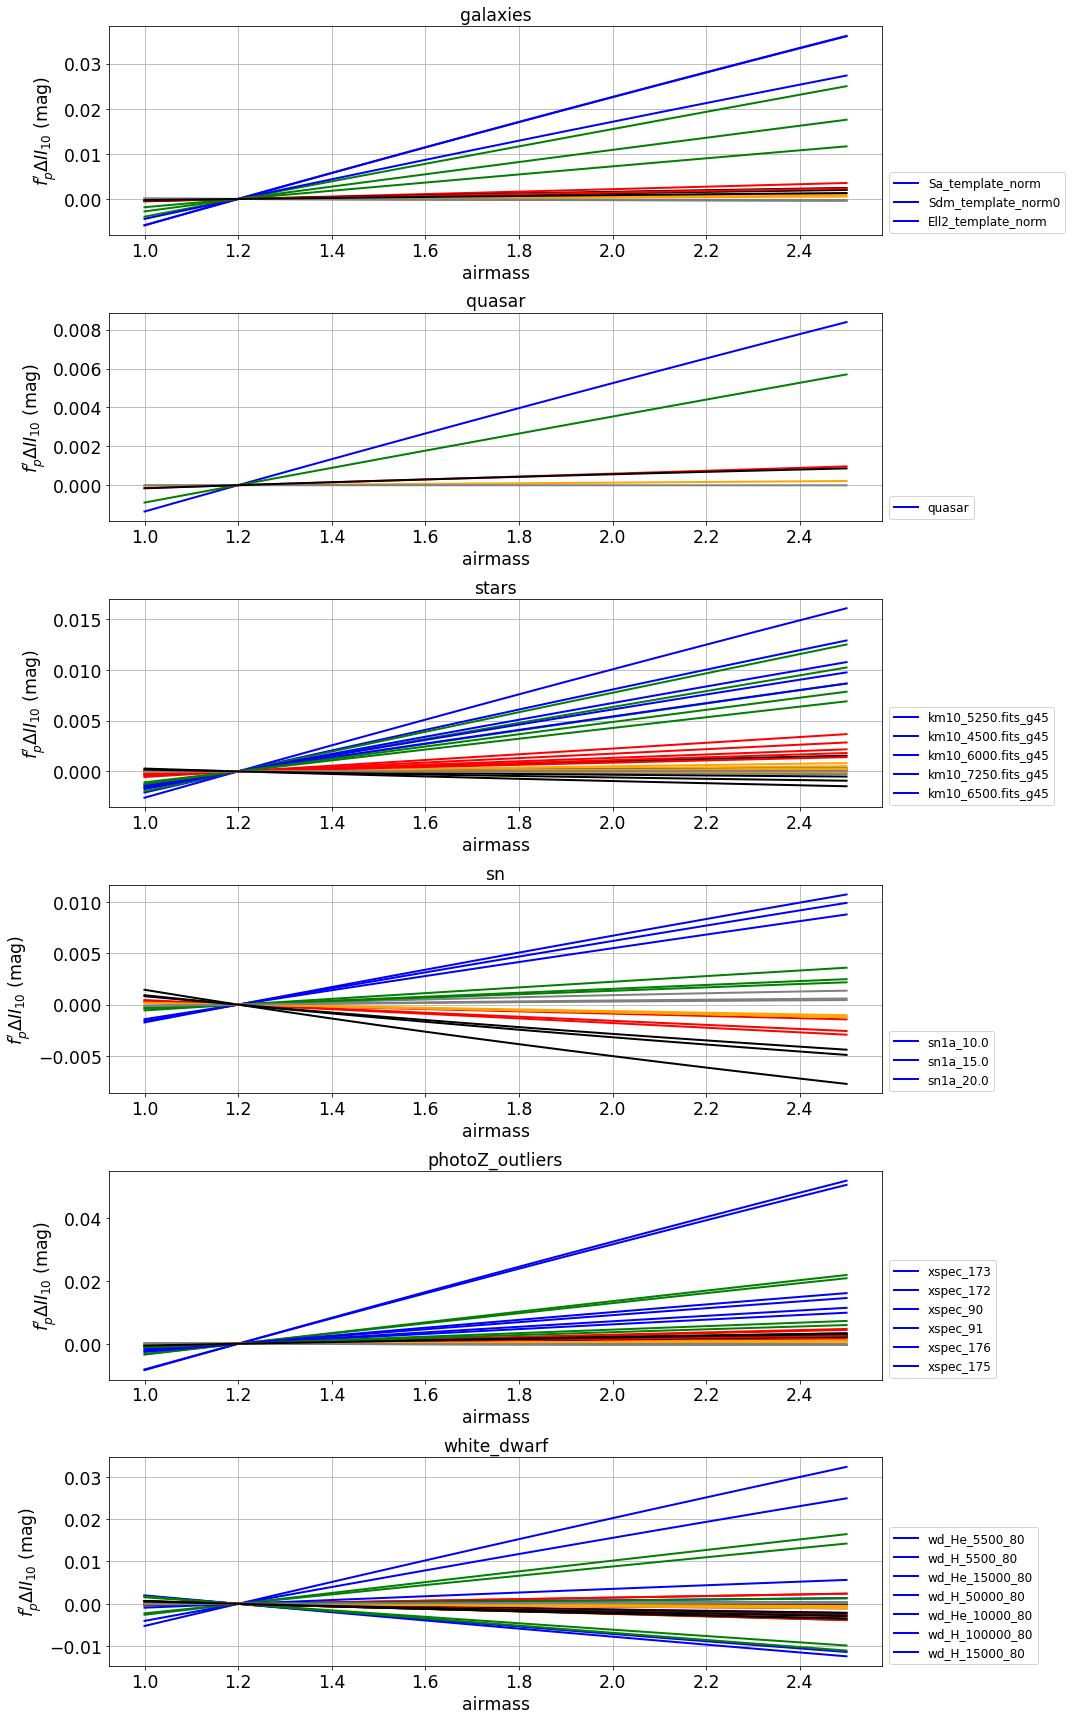

In [91]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(15,NSEDTYPES*4))

old_type = None
idx_sed = -1

# loop on SED
for index_name, row in df_SED_infos.iterrows():
    the_type = row["type"]
    if the_type != old_type:
        idx_sed+=1
        old_type = the_type
        #print(f"new type {the_type} !!!")
        
    #print("\t",index_name,row["type"])
    for ifilt in range(NFILT):
        coeff_tag = "fp_"+ filter_tagnames[ifilt]
        coeff_value = df_SED_infos.loc[index_name][coeff_tag]
        DeltaMag = np.zeros(NAM)
        for idx_am,z in enumerate(all_am):
            Delta_II10 = all_II_diff[idx_am].loc[ifilt]["II10"]
            DeltaMag[idx_am] =  1.087*(Delta_II10*coeff_value)
        if ifilt==0:
            axs[idx_sed].plot(all_am,DeltaMag,color=filter_color[ifilt],label=index_name,lw=2) 
        else:
            axs[idx_sed].plot(all_am,DeltaMag,color=filter_color[ifilt],lw=2)
        
    axs[idx_sed].legend(loc=(1.01, 0.01))
    axs[idx_sed].set_xlabel("airmass")
    axs[idx_sed].set_ylabel("$f^\prime_p \Delta II_{10}$ (mag)")
    axs[idx_sed].set_title(the_type)
    axs[idx_sed].grid()
            
plt.tight_layout()        
        

## Photometric correction with $f_\nu^\prime$ and $f_\nu^{\prime\prime}$ 

### Build the columns tags

In [92]:
from collections import OrderedDict

In [93]:
all_columns = OrderedDict()
all_columns["name"] = 'str'
all_columns["type"] = 'str'
all_columns["filter"] = 'str'
for tag in all_am_tags:
    all_columns[f"c_1_{tag}"] = 'float'
    all_columns[f"c_2_{tag}"] = 'float'
    all_columns[f"c_3_{tag}"] = 'float'
    all_columns[f"c_t_{tag}"] = 'float'
print(all_columns)
print(len(all_columns))

OrderedDict([('name', 'str'), ('type', 'str'), ('filter', 'str'), ('c_1_am_10', 'float'), ('c_2_am_10', 'float'), ('c_3_am_10', 'float'), ('c_t_am_10', 'float'), ('c_1_am_11', 'float'), ('c_2_am_11', 'float'), ('c_3_am_11', 'float'), ('c_t_am_11', 'float'), ('c_1_am_12', 'float'), ('c_2_am_12', 'float'), ('c_3_am_12', 'float'), ('c_t_am_12', 'float'), ('c_1_am_13', 'float'), ('c_2_am_13', 'float'), ('c_3_am_13', 'float'), ('c_t_am_13', 'float'), ('c_1_am_14', 'float'), ('c_2_am_14', 'float'), ('c_3_am_14', 'float'), ('c_t_am_14', 'float'), ('c_1_am_15', 'float'), ('c_2_am_15', 'float'), ('c_3_am_15', 'float'), ('c_t_am_15', 'float'), ('c_1_am_16', 'float'), ('c_2_am_16', 'float'), ('c_3_am_16', 'float'), ('c_t_am_16', 'float'), ('c_1_am_17', 'float'), ('c_2_am_17', 'float'), ('c_3_am_17', 'float'), ('c_t_am_17', 'float'), ('c_1_am_18', 'float'), ('c_2_am_18', 'float'), ('c_3_am_18', 'float'), ('c_t_am_18', 'float'), ('c_1_am_19', 'float'), ('c_2_am_19', 'float'), ('c_3_am_19', 'float')

### Book the dataframe

In [94]:
all_II_diff[15]

II0       II1        II2      II10       II20
0 -0.014692  0.009905  -5.621153  2.320439  -2.992605
1 -0.026603  0.190536 -51.441899  2.693925 -11.993482
2 -0.012920  0.089282 -21.064902  1.147862   5.195948
3 -0.005872  0.026282  -8.098218  0.383888   3.145789
4 -0.002969 -0.008280  -3.574148 -0.177362 -14.807694
5 -0.002402  0.034547  -2.042921  1.639650  36.615670

In [95]:
df_pc_col_airmass = pd.DataFrame(columns=all_columns)

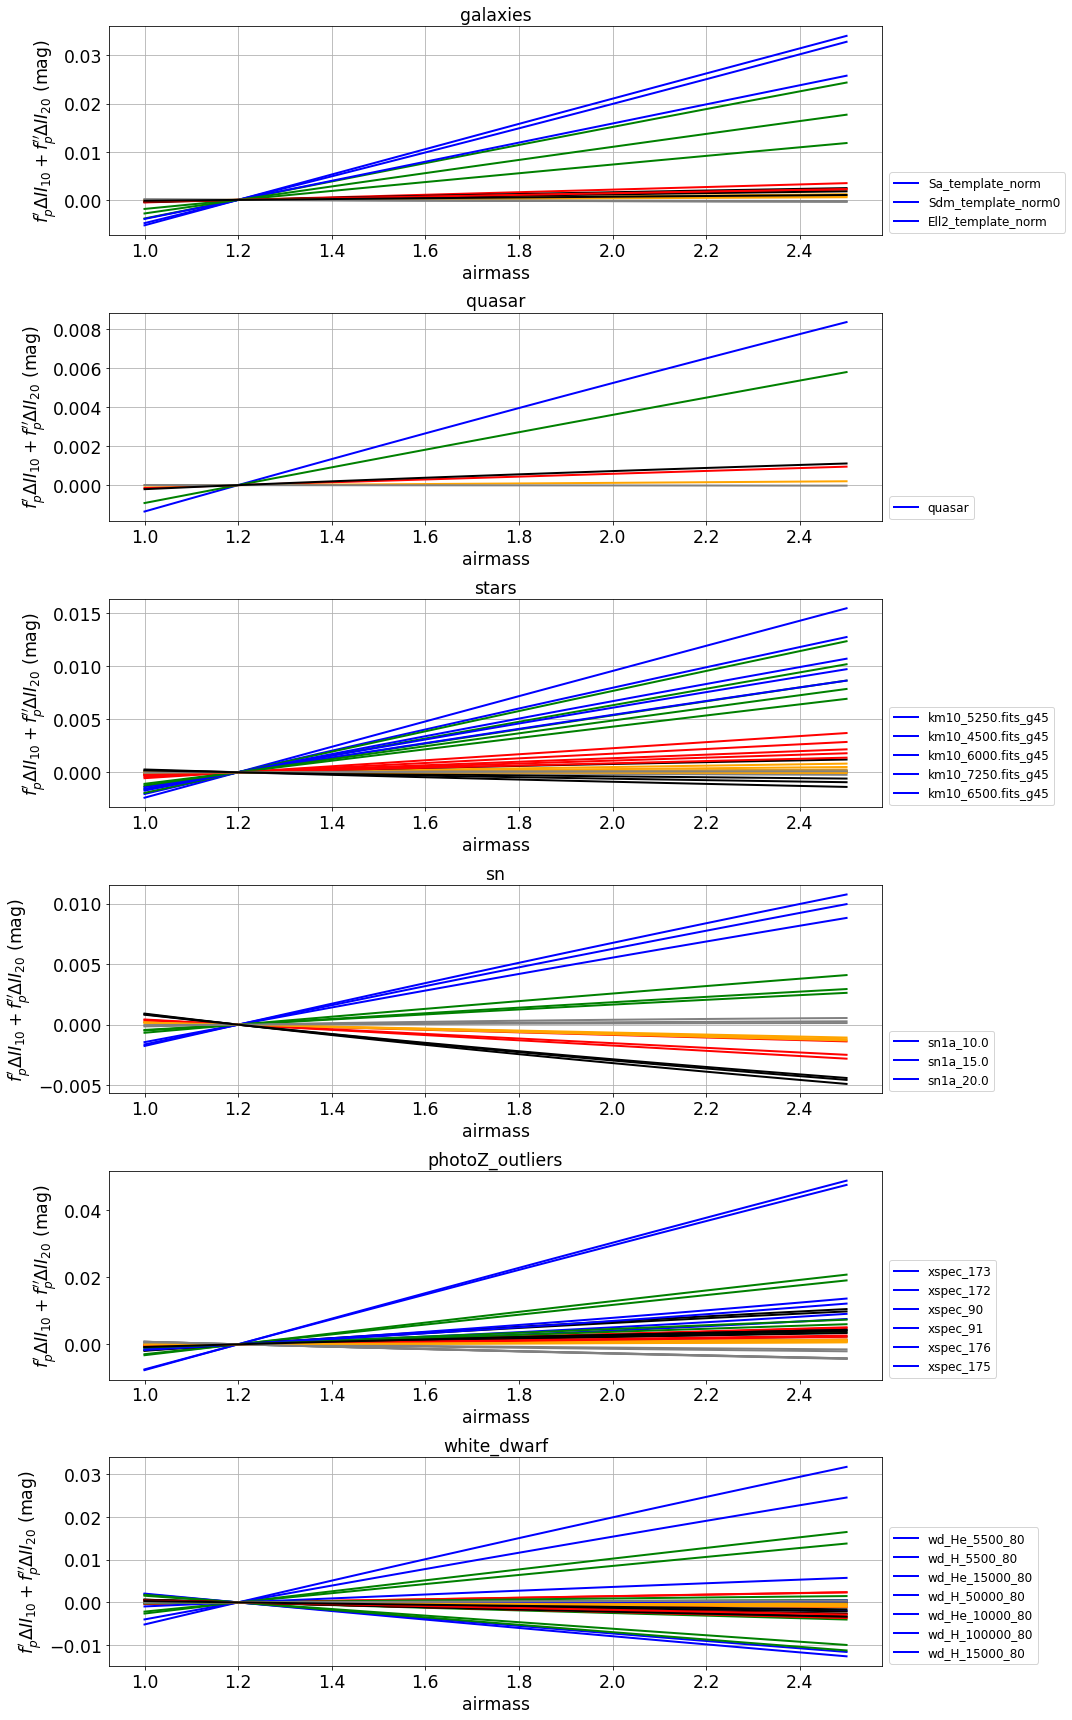

In [96]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(15,NSEDTYPES*4))
K=1.087


old_type = None
idx_sed = -1
idx_type = -1

# loop on SED
for index_name, row in df_SED_infos.iterrows():
    idx_sed += 1
    the_type = row["type"]
    if the_type != old_type:
        idx_type+=1
        old_type = the_type
        #print(f"new type {the_type} !!!")
        
    #print("\t",index_name,row["type"])
    for ifilt in range(NFILT):
        
        list_to_pandas = [index_name, the_type, filter_tagnames[ifilt]]
        
        coeff_tag1 = "fp_"+ filter_tagnames[ifilt]
        coeff_value1 = df_SED_infos.loc[index_name][coeff_tag1]
        coeff_tag2 = "fpp_"+ filter_tagnames[ifilt]
        coeff_value2 = df_SED_infos.loc[index_name][coeff_tag2]
        
        
        # init before loop on airlass
        DeltaMag = np.zeros(NAM)
        # container for mags corrections
        list_data_values = []
        
        # loop on airmass to fill DeltaMag[idx_am] and data_to_pandas
        
        for idx_am,z in enumerate(all_am):
            # get integral difference between observed and standard
            Delta_II10 = all_II_diff[idx_am].loc[ifilt]["II10"]
            Delta_II20 = all_II_diff[idx_am].loc[ifilt]["II20"]
            
            c1 = K*Delta_II10*coeff_value1
            c2 = K*Delta_II20*coeff_value2
            c3 = -K/2*(Delta_II10*coeff_value1)**2
            c4 = c1+c2+c3
            
    
            # fill container for mag correction
            list_data_values.append(c1)
            list_data_values.append(c2)
            list_data_values.append(c3)
            list_data_values.append(c4)
            
            # array for plotting     
            DeltaMag[idx_am] = c4
 

        # make the list
        list_to_pandas = list_to_pandas +  list_data_values
                              
        # add the row to pandas dataframe
        df_pc_col_airmass.loc[idx_sed*6+ifilt] = list_to_pandas
              
              
        # plot for this airmass  for this SED  
        if ifilt==0:
            axs[idx_type].plot(all_am,DeltaMag,color=filter_color[ifilt],label=index_name,lw=2) 
        else:
            axs[idx_type].plot(all_am,DeltaMag,color=filter_color[ifilt],lw=2)
            
        
        
    
    axs[idx_type].legend(loc=(1.01, 0.01))
    axs[idx_type].set_xlabel("airmass")
    axs[idx_type].set_ylabel("$f^\prime_p \Delta II_{10}+ f^{\prime\prime}_p \Delta II_{20} $ (mag)")
    axs[idx_type].set_title(the_type)
    axs[idx_type].grid()
            
plt.tight_layout()        
        

In [97]:
df_pc_col_airmass

name         type filter  c_1_am_10  c_2_am_10     c_3_am_10  \
0    Sa_template_norm     galaxies      u  -0.005829   0.001019 -1.562775e-05   
1    Sa_template_norm     galaxies      g  -0.003926   0.000073 -7.091718e-06   
2    Sa_template_norm     galaxies      r  -0.000538   0.000008 -1.329835e-07   
3    Sa_template_norm     galaxies      i  -0.000159  -0.000028 -1.164718e-08   
4    Sa_template_norm     galaxies      z   0.000084  -0.000002 -3.260711e-09   
..                ...          ...    ...        ...        ...           ...   
145     wd_H_15000_80  white_dwarf      g  -0.000205  -0.000035 -1.927912e-08   
146     wd_H_15000_80  white_dwarf      r   0.000442  -0.000009 -8.985021e-08   
147     wd_H_15000_80  white_dwarf      i   0.000115   0.000002 -6.055583e-09   
148     wd_H_15000_80  white_dwarf      z  -0.000065  -0.000022 -1.944110e-09   
149     wd_H_15000_80  white_dwarf      y   0.000539  -0.000233 -1.336411e-07   

     c_t_am_10  c_1_am_11     c_2_am_11     c_3_am_11  ...     c_3_am_23  \
0    -0.004825  -0.002905  4.878101e-04 -3.881863e-06  ... -4.342438e-04   
1    -0.003861  -0.001961  3.590227e-05 -1.768266e-06  ... -2.070572e-04   
2    -0.000530  -0.000269  4.073338e-06 -3.334812e-08  ... -4.136997e-06   
3    -0.000187  -0.000080 -1.316261e-05 -2.954139e-09  ... -3.980839e-07   
4     0.000082   0.000041 -1.082955e-06 -7.786299e-10  ... -5.732881e-08   
..         ...        ...           ...           ...  ...           ...   
145  -0.000240  -0.000102 -1.728742e-05 -4.807103e-09  ... -5.628933e-07   
146   0.000433   0.000221 -4.735388e-06 -2.253164e-08  ... -2.795160e-06   
147   0.000117   0.000058  9.928137e-07 -1.535911e-09  ... -2.069712e-07   
148  -0.000087  -0.000032 -1.108867e-05 -4.642369e-10  ... -3.418074e-08   
149   0.000306   0.000265 -1.146906e-04 -3.222648e-08  ... -2.838871e-06   

     c_t_am_23  c_1_am_24  c_2_am_24     c_3_am_24  c_t_am_24  c_1_am_25  \
0     0.027630   0.033408  -0.002673 -5.133719e-04   0.030221   0.036072   
1     0.020697   0.023113  -0.000334 -2.457189e-04   0.022533   0.025003   
2     0.002941   0.003274  -0.000060 -4.931451e-06   0.003210   0.003550   
3     0.001007   0.001018   0.000080 -4.763615e-07   0.001097   0.001105   
4    -0.000342  -0.000378   0.000012 -6.563765e-08  -0.000366  -0.000401   
..         ...        ...        ...           ...        ...        ...   
145   0.001256   0.001205   0.000161 -6.679967e-07   0.001365   0.001304   
146  -0.002405  -0.002691   0.000069 -3.331932e-06  -0.002625  -0.002918   
147  -0.000677  -0.000734  -0.000006 -2.476691e-07  -0.000740  -0.000797   
148   0.000382   0.000292   0.000119 -3.913466e-08   0.000411   0.000310   
149  -0.001396  -0.002682   0.001178 -3.308994e-06  -0.001507  -0.002876   

     c_2_am_25     c_3_am_25  c_t_am_25  
0    -0.002649 -5.985135e-04   0.032825  
1    -0.000354 -2.875597e-04   0.024362  
2    -0.000065 -5.796909e-06   0.003479  
3     0.000082 -5.619521e-07   0.001187  
4     0.000012 -7.413197e-08  -0.000389  
..         ...           ...        ...  
145   0.000170 -7.817426e-07   0.001473  
146   0.000076 -3.916678e-06  -0.002846  
147  -0.000006 -2.921693e-07  -0.000803  
148   0.000128 -4.419917e-08   0.000438  
149   0.001264 -3.805723e-06  -0.001616  

[150 rows x 67 columns]

## Error on SED approximation

### Error on Color Photometric Correction bias due to SED approximation
$$
\begin{eqnarray}
\Delta m & = & \left| 2.5 \log_{10}\left(
\frac{\mathbb{I}_0^{std}(b)}
{\mathbb{I}_0^{obs}(b)}\right) +
2.5 \log_{10} 
	\left( 
	\frac{\int_0^\infty F_\nu(\lambda) \times S_b^{obs}(\lambda) \frac{d\lambda}{\lambda} }{\int_0^\infty F_\nu(\lambda) \times S_b^{std}(\lambda) \frac{d\lambda}{\lambda}} 
	\right) \right. \nonumber \\
    & & \left. - 1.087\left( f_\nu^\prime(\lambda_b) \Delta \mathbb{I}_{10}(b) +
          \frac{f_\nu^{\prime\prime}(\lambda_b)}{2}\Delta \mathbb{I}_{20}(b) \right. 
         - \left. \frac{1}{2}\left( f_\nu^\prime(\lambda_b) \Delta \mathbb{I}_{10}(b) \right)^2             
          \right)\right|
\end{eqnarray}  
$$

$$
\begin{eqnarray}
\Delta m & = & \left| 
2.5 \log_{10} 
	\left( 
	\frac{\int_0^\infty F_\nu(\lambda) \times \phi_b^{obs}(\lambda) d\lambda}{\int_0^\infty F_\nu(\lambda) \times \phi_b^{std}(\lambda)d\lambda} 
	\right) \right. \nonumber \\
    & & \left. - 1.087\left( f_\nu^\prime(\lambda_b) \Delta \mathbb{I}_{10}(b) +
          \frac{f_\nu^{\prime\prime}(\lambda_b)}{2}\Delta \mathbb{I}_{20}(b) \right. 
         - \left. \frac{1}{2}\left( f_\nu^\prime(\lambda_b) \Delta \mathbb{I}_{10}(b) \right)^2             
          \right)\right|
\end{eqnarray}  
$$

In [98]:
all_columns = OrderedDict()
all_columns["name"] = 'str'
all_columns["type"] = 'str'
all_columns["filter"] = 'str'
for tag in all_am_tags:
    all_columns[f"ct_{tag}"] = 'float'
print(all_columns)
print(len(all_columns))

OrderedDict([('name', 'str'), ('type', 'str'), ('filter', 'str'), ('ct_am_10', 'float'), ('ct_am_11', 'float'), ('ct_am_12', 'float'), ('ct_am_13', 'float'), ('ct_am_14', 'float'), ('ct_am_15', 'float'), ('ct_am_16', 'float'), ('ct_am_17', 'float'), ('ct_am_18', 'float'), ('ct_am_19', 'float'), ('ct_am_20', 'float'), ('ct_am_21', 'float'), ('ct_am_22', 'float'), ('ct_am_23', 'float'), ('ct_am_24', 'float'), ('ct_am_25', 'float')])
19


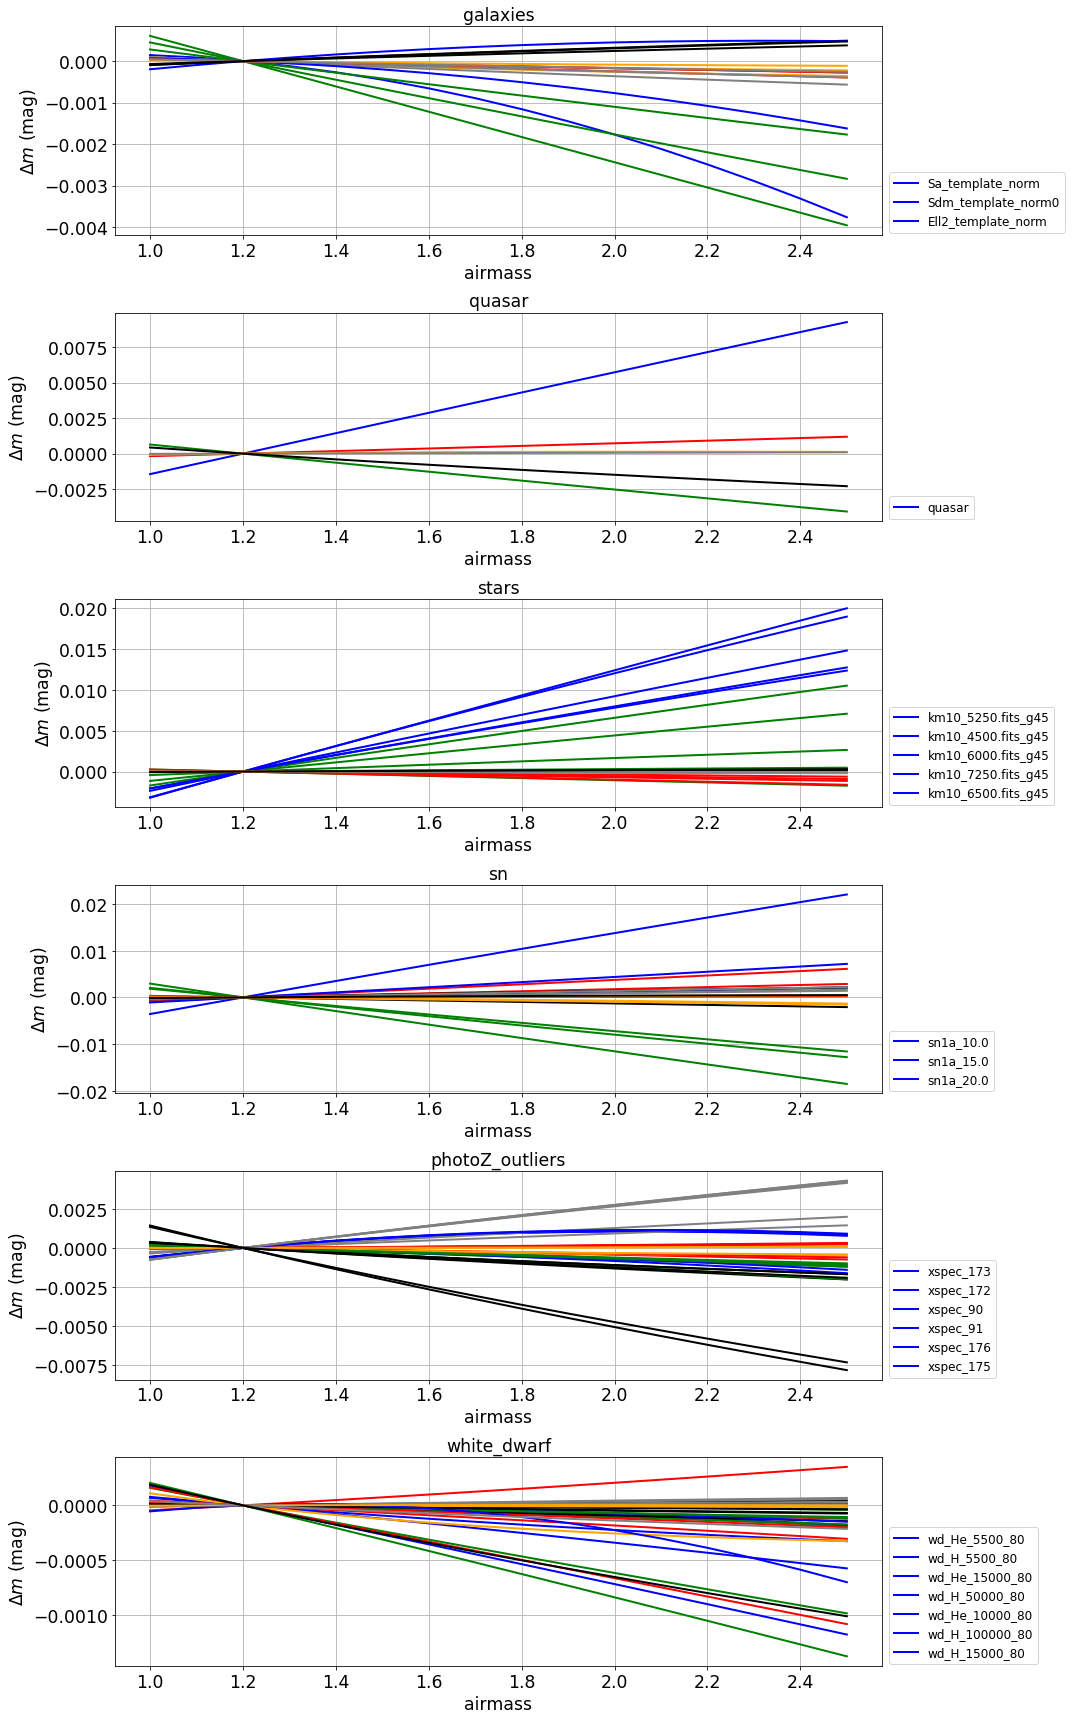

In [99]:
df_pc_col_bias_airmass = pd.DataFrame(columns=all_columns)

fig, axs = plt.subplots(NSEDTYPES,1,figsize=(15,NSEDTYPES*4))
K=1.087

old_type = None
idx_sed = -1


# loop on SED types
for idx_type,sed_type in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[sed_type] 
    NSEDs = len(sednamelist)
    
    
    # loop on objects in sedtypes
    for idx0,sed_name in  enumerate(sednamelist):
        
        idx_sed+=1 
        
        wavel,fnu = seds[sed_name].getSED_fnu()
        
        # loop on filters
        for ifilt in range(NFILT):
            
            list_to_pandas = [sed_name, sed_type, filter_tagnames[ifilt]]
            
            coeff_tag1 = "fp_"+ filter_tagnames[ifilt]
            coeff_value1 = df_SED_infos.loc[sed_name][coeff_tag1]
            coeff_tag2 = "fpp_"+ filter_tagnames[ifilt]
            coeff_value2 = df_SED_infos.loc[sed_name][coeff_tag2]
            
            # init before loop on airlass
            DeltaMag = np.zeros(NAM)
            # container for mags corrections
            list_data_values = []
            
            #print(list_to_pandas)
            
            # loop on airmass
            for idx_am,z in enumerate(all_am):
                #print(all_df_obs[idx_am].head())
                # get integral difference between observed and standard
                
                #approximation
                Delta_II10 = all_II_diff[idx_am].loc[ifilt]["II10"]
                Delta_II20 = all_II_diff[idx_am].loc[ifilt]["II20"]
            
                c1 = K*Delta_II10*coeff_value1
                c2 = K*Delta_II20*coeff_value2
                c3 = -K/2*(Delta_II10*coeff_value1)**2
                c4 = c1+c2+c3
                
                # compute the true integral
                the_df_obs=all_df_obs[idx_am]
                result_integ1 = ComputeAverage(wavel,fnu,the_df_obs)
                result_integ2 = ComputeAverage(wavel,fnu,df_std)
                
                dm=2.5*np.log10(result_integ1[ifilt]/result_integ2[ifilt]) - c4
                
                list_data_values.append(dm)
                DeltaMag[idx_am] = dm
            
            
            # make the list
            list_to_pandas = list_to_pandas +  list_data_values
            
            # add the row to pandas dataframe
            df_pc_col_bias_airmass.loc[idx_sed*6+ifilt] = list_to_pandas
            
            # plot for this airmass  for this SED  
            if ifilt==0:
                axs[idx_type].plot(all_am,DeltaMag,color=filter_color[ifilt],label=sed_name,lw=2) 
            else:
                axs[idx_type].plot(all_am,DeltaMag,color=filter_color[ifilt],lw=2)
            
        
        
    
    axs[idx_type].legend(loc=(1.01, 0.01))
    axs[idx_type].set_xlabel("airmass")
    axs[idx_type].set_ylabel("$\Delta m$ (mag)")
    axs[idx_type].set_title(sed_type)
    axs[idx_type].grid()
            
plt.tight_layout()                
        

In [100]:
df_pc_col_bias_airmass

name         type filter  ct_am_10  ct_am_11  ct_am_12  \
0    Sa_template_norm     galaxies      u  0.000146  0.000088       0.0   
1    Sa_template_norm     galaxies      g  0.000609  0.000305       0.0   
2    Sa_template_norm     galaxies      r  0.000062  0.000031       0.0   
3    Sa_template_norm     galaxies      i  0.000096  0.000046       0.0   
4    Sa_template_norm     galaxies      z  0.000099  0.000049       0.0   
..                ...          ...    ...       ...       ...       ...   
145     wd_H_15000_80  white_dwarf      g  0.000205  0.000103       0.0   
146     wd_H_15000_80  white_dwarf      r  0.000165  0.000083       0.0   
147     wd_H_15000_80  white_dwarf      i -0.000003 -0.000001       0.0   
148     wd_H_15000_80  white_dwarf      z  0.000039  0.000019       0.0   
149     wd_H_15000_80  white_dwarf      y  0.000189  0.000093       0.0   

     ct_am_13  ct_am_14  ct_am_15  ct_am_16  ct_am_17  ct_am_18  ct_am_19  \
0   -0.000119 -0.000268 -0.000447 -0.000655 -0.000891 -0.001156 -0.001449   
1   -0.000305 -0.000609 -0.000914 -0.001218 -0.001523 -0.001827 -0.002131   
2   -0.000031 -0.000061 -0.000092 -0.000122 -0.000153 -0.000183 -0.000214   
3   -0.000042 -0.000080 -0.000116 -0.000149 -0.000179 -0.000207 -0.000234   
4   -0.000048 -0.000096 -0.000142 -0.000188 -0.000233 -0.000277 -0.000320   
..        ...       ...       ...       ...       ...       ...       ...   
145 -0.000103 -0.000207 -0.000312 -0.000416 -0.000522 -0.000627 -0.000734   
146 -0.000083 -0.000166 -0.000249 -0.000332 -0.000415 -0.000498 -0.000582   
147  0.000001  0.000002  0.000002  0.000003  0.000003  0.000003  0.000003   
148 -0.000019 -0.000037 -0.000055 -0.000072 -0.000089 -0.000106 -0.000123   
149 -0.000090 -0.000176 -0.000261 -0.000343 -0.000423 -0.000502 -0.000579   

     ct_am_20  ct_am_21  ct_am_22      ct_am_23      ct_am_24      ct_am_25  
0   -0.001768 -0.002115 -0.002488 -2.886709e-03 -3.310946e-03 -3.760173e-03  
1   -0.002435 -0.002740 -0.003044 -3.347775e-03 -3.651541e-03 -3.955150e-03  
2   -0.000244 -0.000274 -0.000304 -3.345361e-04 -3.645944e-04 -3.945924e-04  
3   -0.000258 -0.000281 -0.000302 -3.214028e-04 -3.398671e-04 -3.571481e-04  
4   -0.000363 -0.000405 -0.000446 -4.864295e-04 -5.263070e-04 -5.655390e-04  
..        ...       ...       ...           ...           ...           ...  
145 -0.000840 -0.000947 -0.001055 -1.162476e-03 -1.270687e-03 -1.379272e-03  
146 -0.000665 -0.000749 -0.000833 -9.168029e-04 -1.000771e-03 -1.084834e-03  
147  0.000002  0.000002  0.000001  7.146688e-07 -1.117727e-08 -8.229094e-07  
148 -0.000139 -0.000155 -0.000170 -1.852724e-04 -2.002359e-04 -2.149302e-04  
149 -0.000654 -0.000728 -0.000801 -8.729956e-04 -9.435243e-04 -1.012994e-03  

[150 rows x 19 columns]